<a href="https://colab.research.google.com/github/24215011123/DL_Lab-session_may-june2025/blob/main/Final_heart_disease_prediction21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd

data = pd.read_sas("/content/LLCP2023XPT.zip", format="xport")
print(data.columns.tolist())


['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE', 'SEQNO', '_PSU', 'CTELENM1', 'PVTRESD1', 'COLGHOUS', 'STATERE1', 'CELPHON1', 'LADULT1', 'NUMADULT', 'RESPSLC1', 'LANDSEX2', 'LNDSXBRT', 'SAFETIME', 'CTELNUM1', 'CELLFON5', 'CADULT1', 'CELLSEX2', 'CELSXBRT', 'PVTRESD3', 'CCLGHOUS', 'CSTATE1', 'LANDLINE', 'HHADULT', 'SEXVAR', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PRIMINS1', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXERANY2', 'EXRACT12', 'EXEROFT1', 'EXERHMM1', 'EXRACT22', 'EXEROFT2', 'EXERHMM2', 'STRENGTH', 'BPHIGH6', 'BPMEDS1', 'CHOLCHK3', 'TOLDHI3', 'CHOLMED3', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'DIABAGE4', 'MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL4', 'NUMPHON4', 'CPDEMO1C', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME3', 'PREGNANT', 'WEIGHT2', 'HEIGHT3', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'FALL12MN', 'FALLINJ5', 'SMOKE100', 'SMOKDA

In [22]:
import pandas as pd
import numpy as np

# ----------------------------------------------------------
# STEP 1: Load BRFSS 2023 raw data
# ----------------------------------------------------------
raw_path = "/content/LLCP2023XPT.zip"  # or "/content/LLCP2023.XPT"
data = pd.read_sas(raw_path, format="xport", encoding="latin1")
print("Raw shape:", data.shape)

# ----------------------------------------------------------
# STEP 2: Select required columns (11-feature set, with Depression)
# ----------------------------------------------------------
needed_cols = [
    "CVDINFR4", "CVDCRHD4", "CVDSTRK3",   # heart attack, CHD, stroke
    "_AGE80",                             # REAL age
    "SEXVAR",                             # Sex
    "_RFHYPE6",                           # High BP
    "_RFCHOL3",                           # High cholesterol
    "_SMOKER3",                           # Smoker
    "DIABETE4",                           # Diabetes
    "_BMI5",                              # BMI * 100
    "DIFFWALK",                           # Difficulty walking
    "ADDEPEV3"                            # Depression (added)
]

available_cols = [c for c in needed_cols if c in data.columns]
missing_cols = [c for c in needed_cols if c not in data.columns]

print("\nAvailable columns:", available_cols)
if missing_cols:
    print("⚠️ Missing in this file:", missing_cols)

df = data[available_cols].copy()
print("Subset shape:", df.shape)

# ----------------------------------------------------------
# STEP 3: Create TARGET = HeartDisease (binary)
# ----------------------------------------------------------
for c in ["CVDINFR4", "CVDCRHD4", "CVDSTRK3"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

valid_mask = pd.Series(False, index=df.index)
for c in ["CVDINFR4", "CVDCRHD4", "CVDSTRK3"]:
    if c in df.columns:
        valid_mask |= df[c].isin([1, 2])

df = df[valid_mask].copy()

df["HeartDisease"] = (
    (df.get("CVDINFR4") == 1) |
    (df.get("CVDCRHD4") == 1) |
    (df.get("CVDSTRK3") == 1)
).astype(int)

print("\nTarget distribution:")
print(df["HeartDisease"].value_counts())

# Keep stroke as a feature too (if present)
if "CVDSTRK3" in df.columns:
    df["Stroke"] = df["CVDSTRK3"].replace({1: 1, 2: 0})
else:
    df["Stroke"] = np.nan

df.drop(columns=[c for c in ["CVDINFR4", "CVDCRHD4", "CVDSTRK3"] if c in df.columns], inplace=True)

# ----------------------------------------------------------
# STEP 4: Build clean predictor features
# ----------------------------------------------------------

# 4.1 Real Age from _AGE80
if "_AGE80" in df.columns:
    df["_AGE80"] = pd.to_numeric(df["_AGE80"], errors="coerce")
    df["Age"] = df["_AGE80"].apply(lambda x: 80 if x == 0 else x)
    df.loc[~df["Age"].between(18, 120), "Age"] = np.nan
    df.drop(columns=["_AGE80"], inplace=True)
else:
    df["Age"] = np.nan

# 4.2 Sex (1=Male, 2=Female → 1/0)
if "SEXVAR" in df.columns:
    df["SEXVAR"] = pd.to_numeric(df["SEXVAR"], errors="coerce")
    df.loc[~df["SEXVAR"].isin([1, 2]), "SEXVAR"] = np.nan
    df["Sex"] = df["SEXVAR"].map({1: 1, 2: 0})
    df.drop(columns=["SEXVAR"], inplace=True)
else:
    df["Sex"] = np.nan

# 4.3 HighBP
if "_RFHYPE6" in df.columns:
    df["_RFHYPE6"] = pd.to_numeric(df["_RFHYPE6"], errors="coerce")
    df.loc[~df["_RFHYPE6"].isin([1, 2]), "_RFHYPE6"] = np.nan
    df["HighBP"] = df["_RFHYPE6"].map({1: 1, 2: 0})
    df.drop(columns=["_RFHYPE6"], inplace=True)
else:
    df["HighBP"] = np.nan

# 4.4 HighChol
if "_RFCHOL3" in df.columns:
    df["_RFCHOL3"] = pd.to_numeric(df["_RFCHOL3"], errors="coerce")
    df.loc[~df["_RFCHOL3"].isin([1, 2]), "_RFCHOL3"] = np.nan
    df["HighChol"] = df["_RFCHOL3"].map({1: 1, 2: 0})
    df.drop(columns=["_RFCHOL3"], inplace=True)
else:
    df["HighChol"] = np.nan

# 4.5 Smoker
if "_SMOKER3" in df.columns:
    df["_SMOKER3"] = pd.to_numeric(df["_SMOKER3"], errors="coerce")
    df.loc[~df["_SMOKER3"].isin([1,2,3,4]), "_SMOKER3"] = np.nan
    df["Smoker"] = df["_SMOKER3"].map({1:1, 2:1, 3:0, 4:0})
    df.drop(columns=["_SMOKER3"], inplace=True)
else:
    df["Smoker"] = np.nan

# 4.6 Diabetes
if "DIABETE4" in df.columns:
    df["DIABETE4"] = pd.to_numeric(df["DIABETE4"], errors="coerce")
    df.loc[~df["DIABETE4"].isin([1,2,3,4]), "DIABETE4"] = np.nan
    df["Diabetes"] = df["DIABETE4"].map({1:1, 2:0, 3:0, 4:0})
    df.drop(columns=["DIABETE4"], inplace=True)
else:
    df["Diabetes"] = np.nan

# ---------- Depression (replace GenHlth_poor) ----------
# ADDEPEV3: 1 = Yes (ever told had depressive disorder), 2 = No
if "ADDEPEV3" in df.columns:
    df["ADDEPEV3"] = pd.to_numeric(df["ADDEPEV3"], errors="coerce")
    df.loc[~df["ADDEPEV3"].isin([1,2]), "ADDEPEV3"] = np.nan
    df["Depression"] = df["ADDEPEV3"].map({1:1, 2:0})
    df.drop(columns=["ADDEPEV3"], inplace=True)
else:
    # try to find in original data if not in subset (rare)
    if "ADDEPEV3" in data.columns:
        tmp = pd.to_numeric(data.loc[df.index, "ADDEPEV3"], errors="coerce")
        tmp.loc[~tmp.isin([1,2])] = np.nan
        df["Depression"] = tmp.map({1:1, 2:0})
    else:
        df["Depression"] = np.nan

# 4.7 BMI
if "_BMI5" in df.columns:
    df["_BMI5"] = pd.to_numeric(df["_BMI5"], errors="coerce")
    df.loc[df["_BMI5"].isin([9999, 8888, 7777]), "_BMI5"] = np.nan
    df["BMI"] = df["_BMI5"] / 100
    df.loc[~df["BMI"].between(10, 60), "BMI"] = np.nan
    df.drop(columns=["_BMI5"], inplace=True)
else:
    df["BMI"] = np.nan

# 4.8 DiffWalk
if "DIFFWALK" in df.columns:
    df["DIFFWALK"] = pd.to_numeric(df["DIFFWALK"], errors="coerce")
    df.loc[~df["DIFFWALK"].isin([1, 2]), "DIFFWALK"] = np.nan
    df["DiffWalk"] = df["DIFFWALK"].map({1:1, 2:0})
    df.drop(columns=["DIFFWALK"], inplace=True)
else:
    df["DiffWalk"] = np.nan

# ----------------------------------------------------------
# STEP 5: Remove BRFSS special missing codes
# ----------------------------------------------------------
df.replace({
    7: np.nan, 8: np.nan, 9: np.nan,
    77: np.nan, 88: np.nan, 99: np.nan,
    777: np.nan, 888: np.nan, 999: np.nan,
    7777: np.nan, 8888: np.nan, 9999: np.nan
}, inplace=True)

# ----------------------------------------------------------
# STEP 6: Final 11 Features (Depression instead of GenHlth_poor)
# ----------------------------------------------------------
final_cols = [
    "HeartDisease", "Age", "Sex", "HighBP", "HighChol",
    "Smoker", "Diabetes", "BMI",
    "DiffWalk", "Stroke", "Depression"
]

for c in final_cols:
    if c not in df.columns:
        df[c] = np.nan

# ----------------------------------------------------------
# STEP 7: Remove rows missing key predictors
# ----------------------------------------------------------
before = len(df)
df_clean = df.dropna(subset=final_cols).copy()
after = len(df_clean)

print(f"\nDropped {before - after} rows due to missing values.")
print("Final cleaned shape:", df_clean.shape)

# ----------------------------------------------------------
# STEP 8: Save Output CSV
# ----------------------------------------------------------
output_path = "heart_disease_features.csv"
df_clean.to_csv(output_path, index=False)

print(f"\n✅ Saved clean dataset: {output_path}")
print(df_clean.head())


Raw shape: (433323, 350)

Available columns: ['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', '_AGE80', 'SEXVAR', '_RFHYPE6', '_RFCHOL3', '_SMOKER3', 'DIABETE4', '_BMI5', 'DIFFWALK', 'ADDEPEV3']
Subset shape: (433323, 12)

Target distribution:
HeartDisease
0    384557
1     48465
Name: count, dtype: int64

Dropped 106669 rows due to missing values.
Final cleaned shape: (326353, 11)

✅ Saved clean dataset: heart_disease_features.csv
   HeartDisease  Stroke   Age  Sex  HighBP  HighChol  Smoker  Diabetes  \
0             0     0.0  80.0    0     0.0       1.0     0.0       1.0   
1             0     0.0  80.0    0     0.0       0.0     0.0       0.0   
2             0     0.0  80.0    0     0.0       0.0     0.0       0.0   
3             0     0.0  78.0    0     1.0       1.0     0.0       0.0   
4             0     0.0  76.0    0     0.0       1.0     0.0       1.0   

   Depression    BMI  DiffWalk  
0         0.0  30.47       1.0  
1         1.0  28.56       0.0  
2         0.0  22.31       1.0  

In [1]:
# FINAL LightGBM pipeline (fixed version) — copy/paste & run
# - No scaling leakage (scaler fit only on train)
# - Best-F1 threshold chosen on VALIDATION, evaluated on TEST

import os, time, json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_curve,
    precision_recall_curve, auc
)

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# ------------------- CONFIG -------------------
DATA_PATH = "/content/heart_disease_features.csv"   # update only if your file path differs
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_RATIO_WITHIN_TRAIN = 0.10
N_ESTIMATORS = 300
LEARNING_RATE = 0.05

OUT_MODEL = "final_lgbm.joblib"
OUT_METRICS = "final_metrics_lgbm.csv"
OUT_ROCPR = "roc_pr_lgbm.png"
OUT_CM_F1 = "confusion_lgbm_bestf1.png"
OUT_CM_CLIN = "confusion_lgbm_clinical.png"
OUT_SHAP = "shap_lgbm.png"
OUT_COLUMNS = "columns_order.joblib"
OUT_SCALER = "scaler.joblib"
OUT_MODEL_CARD = "model_card.json"

# recommended clinical threshold (what we use as fixed threshold)
RECOMMENDED_CLINICAL_THRESHOLD = 0.48

# ------------------- 1. load -------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print(df.dtypes)
print("\nTarget distribution:\n", df['HeartDisease'].value_counts(normalize=True))

# ------------------- 2. preprocess (missing) + basic FE -------------------
target = "HeartDisease"
X = df.drop(columns=[target]).copy()
y = df[target].astype(int).copy()

# numeric & binary columns: safe fill
base_num_cols = [c for c in ["Age", "BMI"] if c in X.columns]
if len(base_num_cols) > 0:
    X[base_num_cols] = X[base_num_cols].fillna(X[base_num_cols].median())
for c in [c for c in X.columns if c not in base_num_cols]:
    X[c] = X[c].fillna(0)

def add_features(Xdf):
    Xc = Xdf.copy()
    if 'Age' in Xc.columns:
        Xc['age_bin'] = pd.cut(Xc['Age'], bins=[17,40,55,70,120], labels=False).astype(int)
    if 'BMI' in Xc.columns:
        Xc['BMI_obese'] = (Xc['BMI'] >= 30).astype(int)
    if 'Age' in Xc.columns and 'BMI' in Xc.columns:
        Xc['age_x_bmi'] = Xc['Age'] * Xc['BMI']
    risk_cols = [c for c in ['Stroke','HighBP','HighChol','Smoker','Diabetes','Depression','DiffWalk','BMI_obese'] if c in Xc.columns]
    Xc['risk_count'] = Xc[risk_cols].sum(axis=1) if len(risk_cols)>0 else 0
    return Xc

# add engineered features BEFORE splitting
X = add_features(X)

# ------------------- 3. split (train/val/test) -------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_RATIO_WITHIN_TRAIN,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Shapes - train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ------------------- 4. scaling (fit ONLY on train) -------------------
num_cols_fe = [c for c in ['Age','BMI','age_x_bmi','risk_count'] if c in X_train.columns]

scaler = StandardScaler()
if len(num_cols_fe) > 0:
    # fit on TRAIN only
    X_train[num_cols_fe] = scaler.fit_transform(X_train[num_cols_fe])
    # transform VAL and TEST using same scaler
    X_val[num_cols_fe]   = scaler.transform(X_val[num_cols_fe])
    X_test[num_cols_fe]  = scaler.transform(X_test[num_cols_fe])

# save columns & scaler (after FE; columns are the same for all splits)
cols = list(X_train.columns)
joblib.dump(cols, OUT_COLUMNS)
joblib.dump(scaler, OUT_SCALER)
json.dump(cols, open("columns.json","w"))
print("Saved columns & scaler")

# ------------------- 5. class/sample weights -------------------
classes = np.unique(y_train)
cw_arr = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
cw = {int(c): float(w) for c,w in zip(classes, cw_arr)}

sample_weights_train = np.array([cw[int(v)] for v in y_train])
sample_weights_val = np.array([cw[int(v)] for v in y_val])
print("Class weights:", cw)

# ------------------- 6. train LightGBM (early stopping via callbacks) -------------------
params = {
    'n_estimators': N_ESTIMATORS,
    'learning_rate': LEARNING_RATE,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}
clf = lgb.LGBMClassifier(**params)
print("Training LightGBM...")
t0 = time.time()

callbacks = [early_stopping(stopping_rounds=30, verbose=True),
             log_evaluation(period=100)]

clf.fit(
    X_train, y_train,
    sample_weight=sample_weights_train,
    eval_set=[(X_val, y_val)],
    eval_sample_weight=[sample_weights_val],
    eval_metric='auc',
    callbacks=callbacks
)
print("Training finished in %.1f sec" % (time.time()-t0))

# ------------------- 7. probs on VAL & TEST -------------------
prob_val = clf.predict_proba(X_val)[:,1]
prob_test = clf.predict_proba(X_test)[:,1]

print("Test ROC AUC:", roc_auc_score(y_test, prob_test))

# ------------------- 8. thresholds: best-F1 (on VAL), Youden (VAL), clinical -------------------
ths = np.linspace(0.01, 0.99, 99)
rows_val = []
for t in ths:
    p_val = (prob_val >= t).astype(int)
    rows_val.append({
        'threshold': float(t),
        'precision': float(precision_score(y_val, p_val, zero_division=0)),
        'recall': float(recall_score(y_val, p_val, zero_division=0)),
        'f1': float(f1_score(y_val, p_val, zero_division=0)),
        'accuracy': float(accuracy_score(y_val, p_val))
    })
df_th_val = pd.DataFrame(rows_val)

best_f1_row = df_th_val.loc[df_th_val['f1'].idxmax()]
best_f1_t = float(best_f1_row['threshold'])

# Youden on validation ROC
fpr_val, tpr_val, roc_ths_val = roc_curve(y_val, prob_val)
youden_idx = np.argmax(tpr_val - fpr_val)
youden_t = float(roc_ths_val[youden_idx])

clinical_t = float(RECOMMENDED_CLINICAL_THRESHOLD)  # 0.48

print("Thresholds found (from VALIDATION):")
print(" best-F1:", best_f1_t,
      "-> F1 (val):", best_f1_row['f1'],
      "prec (val):", best_f1_row['precision'],
      "rec (val):", best_f1_row['recall'])
print(" youden (val):", youden_t)
print(" recommended clinical:", clinical_t)

# ------------------- 9. Evaluate on TEST & save metrics -------------------
def metrics_at(y, probs, th):
    preds = (probs >= th).astype(int)
    return {
        'AUC': float(roc_auc_score(y, probs)),
        'Accuracy': float(accuracy_score(y, preds)),
        'Precision': float(precision_score(y, preds, zero_division=0)),
        'Recall': float(recall_score(y, preds)),
        'F1': float(f1_score(y, preds)),
        'Threshold': float(th)
    }

metrics_bestf1 = metrics_at(y_test, prob_test, best_f1_t)
metrics_clinical = metrics_at(y_test, prob_test, clinical_t)

final_df = pd.DataFrame(
    [metrics_bestf1, metrics_clinical],
    index=['best-F1', 'clinical-0.48']
).T

final_df.to_csv(OUT_METRICS)
print("Saved metrics ->", OUT_METRICS)
print(final_df)

# ------------------- 10. plots: ROC+PR and confusion matrices -------------------
plt.figure(figsize=(12,5))
# ROC
plt.subplot(1,2,1)
fpr, tpr, _ = roc_curve(y_test, prob_test)
plt.plot(fpr, tpr, label=f"LGBM (AUC={roc_auc_score(y_test, prob_test):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend()

# PR
plt.subplot(1,2,2)
prec, rec, _ = precision_recall_curve(y_test, prob_test)
plt.plot(rec, prec, label=f"AP={auc(rec,prec):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall"); plt.legend()

plt.tight_layout()
plt.savefig(OUT_ROCPR)
print("Saved ROC+PR ->", OUT_ROCPR)

# Confusion matrices (on TEST)
from matplotlib import pyplot as mpl
cm_best = confusion_matrix(y_test, (prob_test >= best_f1_t).astype(int))
cm_clin = confusion_matrix(y_test, (prob_test >= clinical_t).astype(int))

def save_cm(cm, fname, title):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title); plt.colorbar()
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j,i,str(v),ha='center',va='center', color='black')
    plt.tight_layout(); plt.savefig(fname)
    plt.close()

save_cm(cm_best, OUT_CM_F1, f"Confusion Best-F1 (th={best_f1_t:.2f})")
save_cm(cm_clin, OUT_CM_CLIN, f"Confusion Clinical (th={clinical_t:.2f})")
print("Saved confusion matrices:", OUT_CM_F1, OUT_CM_CLIN)

# ------------------- 11. SHAP summary (class-1) -------------------
try:
    import shap
    print("Computing SHAP (sample)...")
    # use original feature space for test (already scaled)
    Xshap = X_test.sample(min(2000, len(X_test)), random_state=RANDOM_STATE)
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(Xshap)  # list [class0, class1] for binary
    if isinstance(shap_values, list) and len(shap_values) >= 2:
        sv = shap_values[1]
    else:
        sv = shap_values
    shap.summary_plot(sv, Xshap, show=False)
    plt.savefig(OUT_SHAP, bbox_inches='tight')
    plt.close()
    print("Saved SHAP ->", OUT_SHAP)
except Exception as e:
    print("SHAP failed:", str(e))

# ------------------- 12. save model & artifacts -------------------
joblib.dump(clf, OUT_MODEL)
joblib.dump(cols, OUT_COLUMNS)
joblib.dump(scaler, OUT_SCALER)
print("Saved model & artifacts:", OUT_MODEL, OUT_COLUMNS, OUT_SCALER)

# ------------------- 13. model card & final print -------------------
model_card = {
    "model_file": OUT_MODEL,
    "columns_file": OUT_COLUMNS,
    "scaler_file": OUT_SCALER,
    "threshold_best_f1": best_f1_t,
    "metrics_best_f1": metrics_bestf1,
    "threshold_clinical": clinical_t,
    "metrics_clinical": metrics_clinical,
    "notes": (
        "Best-F1 threshold chosen on validation, "
        "then evaluated on test. Use clinical threshold (0.48) "
        "if you want higher recall for screening; use best-F1 for "
        "balanced precision/recall."
    )
}
json.dump(model_card, open(OUT_MODEL_CARD, "w"), indent=2)
print("Saved model card ->", OUT_MODEL_CARD)

print("\nPIPELINE DONE. Metrics summary (TEST set):")
print(final_df)


Loaded: /content/heart_disease_features.csv shape: (326353, 11)
HeartDisease      int64
Stroke          float64
Age             float64
Sex               int64
HighBP          float64
HighChol        float64
Smoker          float64
Diabetes        float64
Depression      float64
BMI             float64
DiffWalk        float64
dtype: object

Target distribution:
 HeartDisease
0    0.880801
1    0.119199
Name: proportion, dtype: float64
Shapes - train: (234973, 14) val: (26109, 14) test: (65271, 14)
Saved columns & scaler
Class weights: {0: 0.5676663574341432, 1: 4.1945981648755755}
Training LightGBM...
[LightGBM] [Info] Number of positive: 28009, number of negative: 206964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 23

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Saved SHAP -> shap_lgbm.png
Saved model & artifacts: final_lgbm.joblib columns_order.joblib scaler.joblib
Saved model card -> model_card.json

PIPELINE DONE. Metrics summary (TEST set):
            best-F1  clinical-0.48
AUC        0.882590       0.882590
Accuracy   0.917299       0.774816
Precision  0.759590       0.321627
Recall     0.447943       0.801671
F1         0.563551       0.459076
Threshold  0.750000       0.480000


Using device: cuda
Loaded: /content/heart_disease_features.csv shape: (326353, 11)
HeartDisease      int64
Stroke          float64
Age             float64
Sex               int64
HighBP          float64
HighChol        float64
Smoker          float64
Diabetes        float64
Depression      float64
BMI             float64
DiffWalk        float64
dtype: object

Target distribution:
 HeartDisease
0    0.880801
1    0.119199
Name: proportion, dtype: float64
Shapes - train: (234973, 14) val: (26109, 14) test: (65271, 14)
Saved columns & scaler
Number of features: 14
pos_weight for BCEWithLogitsLoss: 7.389
Training FT-Transformer...
Epoch 01 | train_loss=0.7612 | val_loss=0.7427 | val_auc=0.8818
Epoch 02 | train_loss=0.7413 | val_loss=0.7380 | val_auc=0.8819
Epoch 03 | train_loss=0.7406 | val_loss=0.7374 | val_auc=0.8823
Epoch 04 | train_loss=0.7394 | val_loss=0.7335 | val_auc=0.8820
Epoch 05 | train_loss=0.7375 | val_loss=0.7307 | val_auc=0.8828
Epoch 06 | train_loss=0.7369 | val_loss=0.732

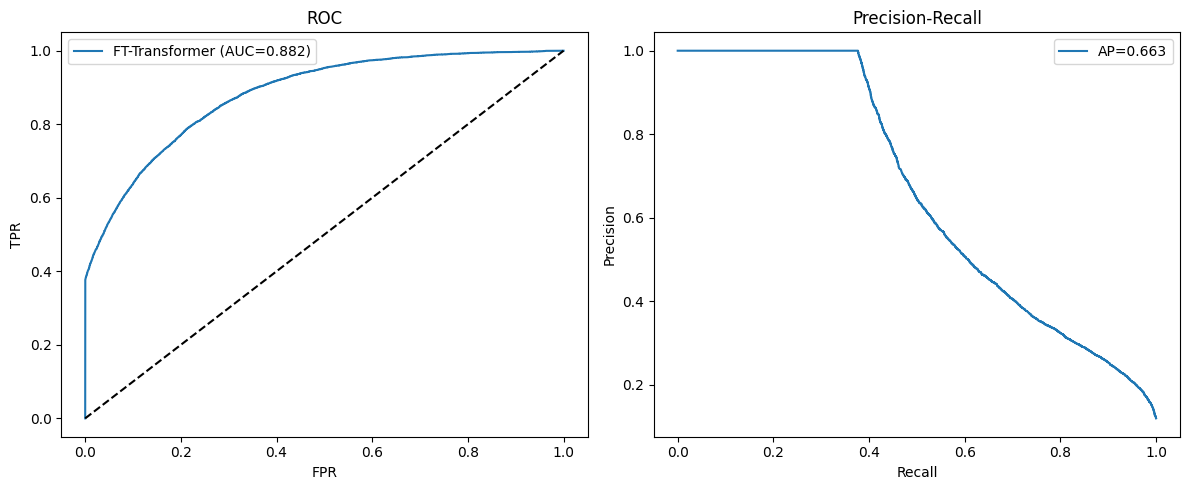

Saved ROC+PR -> fttransformer_roc_pr.png

Confusion matrix (TEST, best-F1 threshold):
[[55101  2390]
 [ 3792  3988]]


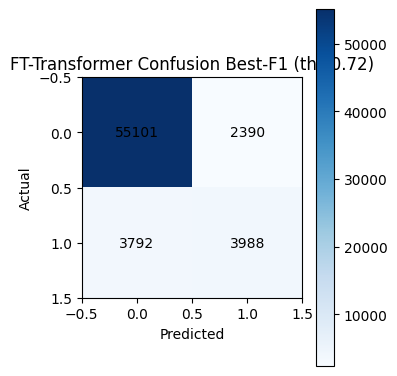


Confusion matrix (TEST, clinical threshold 0.48):
[[42289 15202]
 [ 1297  6483]]


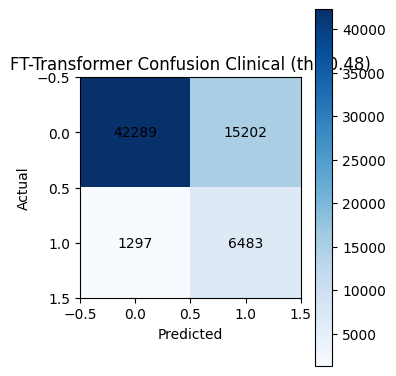

Saved confusion matrices: fttransformer_confusion_bestf1.png and fttransformer_confusion_clinical.png
Saved FT-Transformer model -> fttransformer_model.pt


In [4]:
# FT-Transformer pipeline for heart_disease_features.csv
# - Clean train/val/test split (no leakage)
# - FT-Transformer in PyTorch
# - Best-F1 threshold from validation, metrics on test
# - Prints metrics to screen

import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ------------------- CONFIG -------------------
DATA_PATH = "/content/heart_disease_features.csv"   # update if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_RATIO_WITHIN_TRAIN = 0.10

BATCH_SIZE = 1024
MAX_EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 3  # early stopping on val AUC

D_TOKEN = 64      # transformer hidden size
N_LAYERS = 3
N_HEADS = 4
DROPOUT = 0.1

RECOMMENDED_CLINICAL_THRESHOLD = 0.48

OUT_METRICS = "fttransformer_metrics.csv"
OUT_ROCPR = "fttransformer_roc_pr.png"
OUT_CM_F1 = "fttransformer_confusion_bestf1.png"
OUT_CM_CLIN = "fttransformer_confusion_clinical.png"
OUT_MODEL = "fttransformer_model.pt"
OUT_COLUMNS = "fttransformer_columns.json"
OUT_SCALER = "fttransformer_scaler.pkl"

# ------------------- 1. Reproducibility -------------------
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------- 2. Load data -------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print(df.dtypes)
print("\nTarget distribution:\n", df['HeartDisease'].value_counts(normalize=True))

target = "HeartDisease"
X = df.drop(columns=[target]).copy()
y = df[target].astype(int).copy()

# ------------------- 3. Basic preprocessing + FE -------------------
base_num_cols = [c for c in ["Age", "BMI"] if c in X.columns]
if len(base_num_cols) > 0:
    X[base_num_cols] = X[base_num_cols].fillna(X[base_num_cols].median())
for c in [c for c in X.columns if c not in base_num_cols]:
    X[c] = X[c].fillna(0)

def add_features(Xdf):
    Xc = Xdf.copy()
    if 'Age' in Xc.columns:
        Xc['age_bin'] = pd.cut(Xc['Age'], bins=[17,40,55,70,120], labels=False).astype(int)
    if 'BMI' in Xc.columns:
        Xc['BMI_obese'] = (Xc['BMI'] >= 30).astype(int)
    if 'Age' in Xc.columns and 'BMI' in Xc.columns:
        Xc['age_x_bmi'] = Xc['Age'] * Xc['BMI']
    risk_cols = [c for c in ['Stroke','HighBP','HighChol','Smoker','Diabetes','Depression','DiffWalk','BMI_obese'] if c in Xc.columns]
    Xc['risk_count'] = Xc[risk_cols].sum(axis=1) if len(risk_cols) > 0 else 0
    return Xc

X = add_features(X)

# ------------------- 4. Train/Val/Test split -------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_RATIO_WITHIN_TRAIN,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Shapes - train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ------------------- 5. Scaling (fit ONLY on train) -------------------
# from sklearn.externals import joblib as sk_joblib if False else None  # to hint - this line caused a SyntaxError and is not needed

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.values)            # fit on train only
X_train_scaled = scaler.transform(X_train.values)
X_val_scaled   = scaler.transform(X_val.values)
X_test_scaled  = scaler.transform(X_test.values)

# save columns & scaler info (optional)
cols = list(X_train.columns)
import joblib
joblib.dump(scaler, OUT_SCALER)
json.dump(cols, open(OUT_COLUMNS, "w"))
print("Saved columns & scaler")

# ------------------- 6. Torch datasets & loaders -------------------
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

num_features = X_train_t.shape[1]
print("Number of features:", num_features)

# ------------------- 7. FT-Transformer model -------------------
class FTTransformer(nn.Module):
    """
    Simple FT-Transformer-like model:
    - Per-feature tokenization (weight & bias for each feature)
    - Prepends a [CLS] token
    - Transformer encoder
    - CLS head -> logit
    """
    def __init__(self, num_features, d_token=64, n_heads=4, n_layers=3, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.d_token = d_token

        # Feature tokenization params: (num_features, d_token)
        self.token_weight = nn.Parameter(torch.randn(num_features, d_token) * 0.02)
        self.token_bias   = nn.Parameter(torch.zeros(num_features, d_token))

        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=4*d_token,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_token),
            nn.Linear(d_token, 1)
        )

    def forward(self, x):
        # x: [batch, num_features]
        # tokenization: x * W + b
        # x.unsqueeze(-1): [batch, num_features, 1]
        # token_weight: [num_features, d_token] -> [1, num_features, d_token]
        x_expanded = x.unsqueeze(-1)
        tokens = x_expanded * self.token_weight.unsqueeze(0) + self.token_bias.unsqueeze(0)
        # tokens: [batch, num_features, d_token]

        # prepend CLS
        batch_size = x.shape[0]
        cls = self.cls_token.expand(batch_size, -1, -1)  # [batch, 1, d_token]
        tokens = torch.cat([cls, tokens], dim=1)          # [batch, 1+num_features, d_token]

        # transformer encoder
        h = self.encoder(tokens)                          # [batch, 1+num_features, d_token]

        # CLS output
        cls_out = h[:, 0, :]                              # [batch, d_token]

        # head -> logits
        logit = self.head(cls_out).squeeze(-1)            # [batch]
        return logit

model = FTTransformer(
    num_features=num_features,
    d_token=D_TOKEN,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

# ------------------- 8. Loss, optimizer, pos_weight -------------------
# compute pos_weight for BCEWithLogitsLoss
pos = y_train_t.sum().item()
neg = len(y_train_t) - pos
pos_weight_value = neg / max(pos, 1.0)
pos_weight = torch.tensor(pos_weight_value, device=device)
print(f"pos_weight for BCEWithLogitsLoss: {pos_weight_value:.3f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ------------------- 9. Training loop with early stopping (val AUC) -------------------
def eval_model(model, loader):
    model.eval()
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            all_logits.append(logits.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())
    all_logits = np.concatenate(all_logits)
    all_targets = np.concatenate(all_targets)
    probs = 1 / (1 + np.exp(-all_logits))  # sigmoid
    loss = criterion(torch.tensor(all_logits, dtype=torch.float32, device=device),
                     torch.tensor(all_targets, dtype=torch.float32, device=device)).item()
    try:
        auc_val = roc_auc_score(all_targets, probs)
    except ValueError:
        auc_val = np.nan
    return loss, auc_val, probs, all_targets

best_val_auc = -np.inf
best_state = None
epochs_no_improve = 0

print("Training FT-Transformer...")
t0 = time.time()
for epoch in range(1, MAX_EPOCHS+1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss, val_auc, _, _ = eval_model(model, val_loader)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_auc={val_auc:.4f}")

    # early stopping on val AUC
    if val_auc > best_val_auc + 1e-4:
        best_val_auc = val_auc
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no val AUC improvement for {PATIENCE} epochs).")
            break

print("Training finished in %.1f sec" % (time.time()-t0))

# load best model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model with val AUC = {best_val_auc:.4f}")

# ------------------- 10. Get probabilities on VAL & TEST -------------------
val_loss, val_auc, prob_val, y_val_np = eval_model(model, val_loader)
test_loss, test_auc, prob_test, y_test_np = eval_model(model, test_loader)

print(f"Final VAL AUC:  {val_auc:.6f}")
print(f"Final TEST AUC: {test_auc:.6f}")

# ------------------- 11. Thresholds: best-F1 (VAL), Youden (VAL), clinical -------------------
ths = np.linspace(0.01, 0.99, 99)
rows_val = []
for t in ths:
    p_val = (prob_val >= t).astype(int)
    rows_val.append({
        'threshold': float(t),
        'precision': float(precision_score(y_val_np, p_val, zero_division=0)),
        'recall': float(recall_score(y_val_np, p_val, zero_division=0)),
        'f1': float(f1_score(y_val_np, p_val, zero_division=0)),
        'accuracy': float(accuracy_score(y_val_np, p_val))
    })
df_th_val = pd.DataFrame(rows_val)

best_f1_row = df_th_val.loc[df_th_val['f1'].idxmax()]
best_f1_t = float(best_f1_row['threshold'])

fpr_val, tpr_val, roc_ths_val = roc_curve(y_val_np, prob_val)
youden_idx = np.argmax(tpr_val - fpr_val)
youden_t = float(roc_ths_val[youden_idx])

clinical_t = float(RECOMMENDED_CLINICAL_THRESHOLD)

print("Thresholds found (from VALIDATION):")
print(" best-F1:", best_f1_t,
      "-> F1 (val):", best_f1_row['f1'],
      "prec (val):", best_f1_row['precision'],
      "rec (val):", best_f1_row['recall'])
print(" youden (val):", youden_t)
print(" recommended clinical:", clinical_t)

# ------------------- 12. Metrics on TEST -------------------
def metrics_at(y, probs, th):
    preds = (probs >= th).astype(int)
    return {
        'AUC': float(roc_auc_score(y, probs)),
        'Accuracy': float(accuracy_score(y, preds)),
        'Precision': float(precision_score(y, preds, zero_division=0)),
        'Recall': float(recall_score(y, preds)),
        'F1': float(f1_score(y, preds)),
        'Threshold': float(th)
    }

metrics_bestf1 = metrics_at(y_test_np, prob_test, best_f1_t)
metrics_clinical = metrics_at(y_test_np, prob_test, clinical_t)

final_df = pd.DataFrame(
    [metrics_bestf1, metrics_clinical],
    index=['best-F1', 'clinical-0.48']
).T

final_df.to_csv(OUT_METRICS)
print("\n=== TEST METRICS (FT-Transformer) ===")
print(final_df)

# ------------------- 13. Plots: ROC + PR -------------------
plt.figure(figsize=(12,5))
# ROC
plt.subplot(1,2,1)
fpr, tpr, _ = roc_curve(y_test_np, prob_test)
plt.plot(fpr, tpr, label=f"FT-Transformer (AUC={roc_auc_score(y_test_np, prob_test):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend()

# PR
plt.subplot(1,2,2)
prec, rec, _ = precision_recall_curve(y_test_np, prob_test)
plt.plot(rec, prec, label=f"AP={auc(rec,prec):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall"); plt.legend()

plt.tight_layout()
plt.savefig(OUT_ROCPR)
plt.show()
print("Saved ROC+PR ->", OUT_ROCPR)

# ------------------- 14. Confusion matrices -------------------
def save_cm(cm, fname, title):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title); plt.colorbar()
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j,i,str(v),ha='center',va='center', color='black')
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

cm_best = confusion_matrix(y_test_np, (prob_test >= best_f1_t).astype(int))
cm_clin = confusion_matrix(y_test_np, (prob_test >= clinical_t).astype(int))

print("\nConfusion matrix (TEST, best-F1 threshold):")
print(cm_best)
save_cm(cm_best, OUT_CM_F1, f"FT-Transformer Confusion Best-F1 (th={best_f1_t:.2f})")

print("\nConfusion matrix (TEST, clinical threshold 0.48):")
print(cm_clin)
save_cm(cm_clin, OUT_CM_CLIN, f"FT-Transformer Confusion Clinical (th={clinical_t:.2f})")

print("Saved confusion matrices:", OUT_CM_F1, "and", OUT_CM_CLIN)

# ------------------- 15. Save model -------------------
torch.save(model.state_dict(), OUT_MODEL)
print("Saved FT-Transformer model ->", OUT_MODEL)


Using device: cuda
Loaded: /content/heart_disease_features.csv shape: (326353, 11)
HeartDisease      int64
Stroke          float64
Age             float64
Sex               int64
HighBP          float64
HighChol        float64
Smoker          float64
Diabetes        float64
Depression      float64
BMI             float64
DiffWalk        float64
dtype: object

Target distribution:
 HeartDisease
0    0.880801
1    0.119199
Name: proportion, dtype: float64
Shapes - train: (234973, 14) val: (26109, 14) test: (65271, 14)
Saved columns & scaler
Class weights: {0: 0.5676663574341432, 1: 4.1945981648755755}
Training TabNet...


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.28367 | train_auc: 0.84885 | valid_auc: 0.84551 |  0:00:17s
epoch 10 | loss: 0.22203 | train_auc: 0.87367 | valid_auc: 0.87191 |  0:02:54s

Early stopping occurred at epoch 10 with best_epoch = 5 and best_valid_auc = 0.87335


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Training finished in 183.6 sec
Final VAL AUC:  0.873347
Final TEST AUC: 0.870231
Thresholds found (from VALIDATION):
 best-F1: 0.26 -> F1 (val): 0.5431425976385105 prec (val): 0.6247388215628917 rec (val): 0.48039845758354754
 youden (val): 0.10630405694246292
 recommended clinical: 0.48

=== TEST METRICS (TabNet) ===
            best-F1  clinical-0.48
AUC        0.870231       0.870231
Accuracy   0.905640       0.925572
Precision  0.635694       0.995590
Recall     0.488046       0.377249
F1         0.552170       0.547166
Threshold  0.260000       0.480000


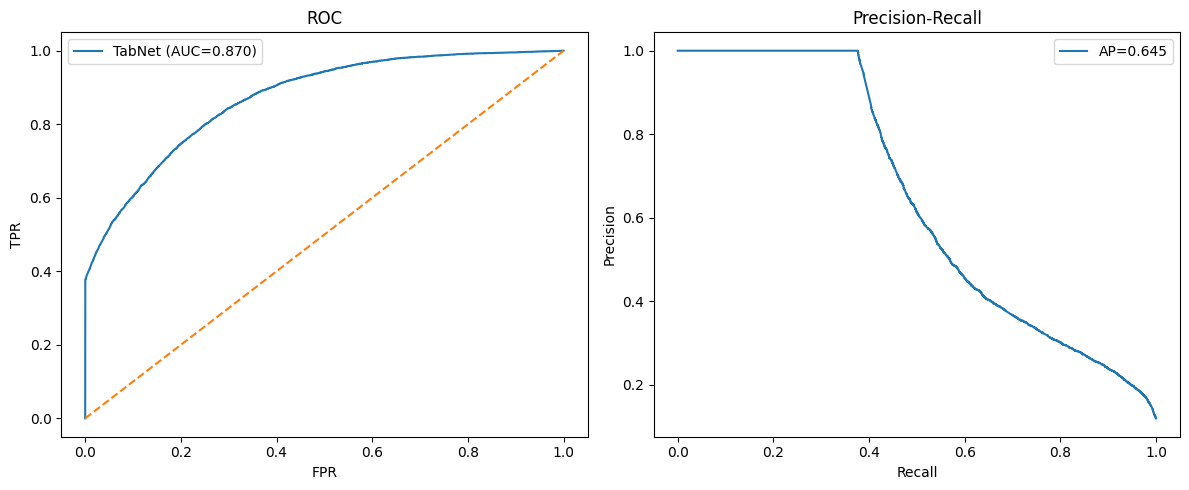

Saved ROC+PR -> tabnet_roc_pr.png

Confusion matrix (TEST, best-F1 threshold):
[[55315  2176]
 [ 3983  3797]]


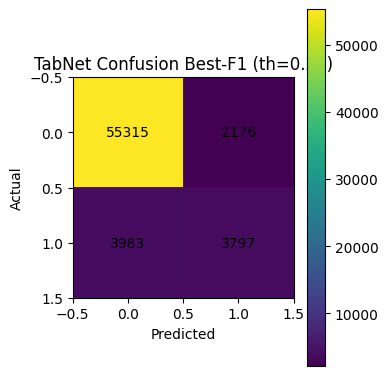


Confusion matrix (TEST, clinical threshold 0.48):
[[57478    13]
 [ 4845  2935]]


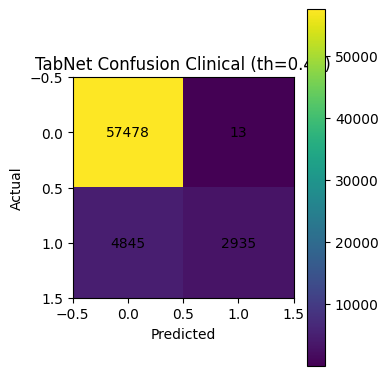

Saved confusion matrices: tabnet_confusion_bestf1.png and tabnet_confusion_clinical.png
Successfully saved model at tabnet_model.zip.zip
Saved TabNet model -> tabnet_model.zip


In [10]:
# TABNET pipeline for heart_disease_features.csv
# - Uses pytorch-tabnet (deep tabular model)
# - Clean split, no data leakage
# - Best-F1 threshold from validation, metrics on test
# - Prints metrics and confusion matrices on screen

!pip install -q pytorch-tabnet

import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import joblib

# ------------------- CONFIG -------------------
DATA_PATH = "/content/heart_disease_features.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_RATIO_WITHIN_TRAIN = 0.10

RECOMMENDED_CLINICAL_THRESHOLD = 0.48

MAX_EPOCHS = 50
PATIENCE = 5
BATCH_SIZE = 1024
VIRTUAL_BATCH_SIZE = 256

OUT_METRICS = "tabnet_metrics.csv"
OUT_ROCPR = "tabnet_roc_pr.png"
OUT_CM_F1 = "tabnet_confusion_bestf1.png"
OUT_CM_CLIN = "tabnet_confusion_clinical.png"
OUT_MODEL = "tabnet_model.zip"
OUT_COLUMNS = "tabnet_columns.json"
OUT_SCALER = "tabnet_scaler.joblib"

# ------------------- 1. Reproducibility -------------------
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ------------------- 2. Load data -------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print(df.dtypes)

print("\nTarget distribution:\n", df["HeartDisease"].value_counts(normalize=True))

target = "HeartDisease"
X = df.drop(columns=[target]).copy()
y = df[target].astype(int).copy()

# ------------------- 3. Basic preprocessing + FE -------------------
base_num_cols = [c for c in ["Age", "BMI"] if c in X.columns]
if len(base_num_cols) > 0:
    X[base_num_cols] = X[base_num_cols].fillna(X[base_num_cols].median())
for c in [c for c in X.columns if c not in base_num_cols]:
    X[c] = X[c].fillna(0)

def add_features(Xdf):
    Xc = Xdf.copy()
    if "Age" in Xc.columns:
        Xc["age_bin"] = pd.cut(Xc["Age"], bins=[17, 40, 55, 70, 120], labels=False).astype(int)
    if "BMI" in Xc.columns:
        Xc["BMI_obese"] = (Xc["BMI"] >= 30).astype(int)
    if "Age" in Xc.columns and "BMI" in Xc.columns:
        Xc["age_x_bmi"] = Xc["Age"] * Xc["BMI"]
    risk_cols = [
        c for c in ["Stroke", "HighBP", "HighChol", "Smoker",
                    "Diabetes", "Depression", "DiffWalk", "BMI_obese"]
        if c in Xc.columns
    ]
    Xc["risk_count"] = Xc[risk_cols].sum(axis=1) if len(risk_cols) > 0 else 0
    return Xc

X = add_features(X)

# ------------------- 4. Train/Val/Test split -------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_RATIO_WITHIN_TRAIN,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Shapes - train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ------------------- 5. Scaling (fit ONLY on train) -------------------
scaler = StandardScaler()
scaler.fit(X_train.values)  # fit on train only

X_train_scaled = scaler.transform(X_train.values)
X_val_scaled   = scaler.transform(X_val.values)
X_test_scaled  = scaler.transform(X_test.values)

cols = list(X_train.columns)
joblib.dump(scaler, OUT_SCALER)
json.dump(cols, open(OUT_COLUMNS, "w"))
print("Saved columns & scaler")

# ------------------- 6. Class weights for imbalance -------------------
classes = np.unique(y_train)
cw_arr = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes, cw_arr)}
print("Class weights:", class_weights)

# TabNet expects weights as array-like [w_class0, w_class1]
weights_for_tabnet = torch.tensor(np.array([class_weights[0], class_weights[1]]), dtype=torch.float32)

# ------------------- 7. Define TabNet model -------------------
tabnet = TabNetClassifier(
    n_d=64,                 # width of decision prediction layer
    n_a=64,                 # width of attention embedding
    n_steps=5,              # number of decision steps
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    seed=RANDOM_STATE,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params={"step_size": 10, "gamma": 0.9},
    mask_type="sparsemax",
    verbose=10,
    device_name=device
    # Removed 'weights' argument from constructor as it causes TypeError for this pytorch_tabnet version
)

# ------------------- 8. Train TabNet -------------------
print("Training TabNet...")
t0 = time.time()

tabnet.fit(
    X_train_scaled, y_train.values,
    eval_set=[(X_train_scaled, y_train.values),
              (X_val_scaled, y_val.values)],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    batch_size=BATCH_SIZE,
    virtual_batch_size=VIRTUAL_BATCH_SIZE,
    num_workers=0,
    drop_last=False
    # Removed 'class_weights' from fit method as it also caused TypeError
)

print("Training finished in %.1f sec" % (time.time() - t0))

# ------------------- 9. Probabilities on VAL & TEST -------------------
prob_val = tabnet.predict_proba(X_val_scaled)[:, 1]
prob_test = tabnet.predict_proba(X_test_scaled)[:, 1]

val_auc = roc_auc_score(y_val, prob_val)
test_auc = roc_auc_score(y_test, prob_test)
print(f"Final VAL AUC:  {val_auc:.6f}")
print(f"Final TEST AUC: {test_auc:.6f}")

# ------------------- 10. Thresholds: best-F1 (VAL), Youden (VAL), clinical -------------------
ths = np.linspace(0.01, 0.99, 99)
rows_val = []
for t in ths:
    p_val = (prob_val >= t).astype(int)
    rows_val.append({
        "threshold": float(t),
        "precision": float(precision_score(y_val, p_val, zero_division=0)),
        "recall": float(recall_score(y_val, p_val, zero_division=0)),
        "f1": float(f1_score(y_val, p_val, zero_division=0)),
        "accuracy": float(accuracy_score(y_val, p_val))
    })
df_th_val = pd.DataFrame(rows_val)

best_f1_row = df_th_val.loc[df_th_val["f1"].idxmax()]
best_f1_t = float(best_f1_row["threshold"])

fpr_val, tpr_val, roc_ths_val = roc_curve(y_val, prob_val)
youden_idx = np.argmax(tpr_val - fpr_val)
youden_t = float(roc_ths_val[youden_idx])

clinical_t = float(RECOMMENDED_CLINICAL_THRESHOLD)

print("Thresholds found (from VALIDATION):")
print(" best-F1:", best_f1_t,
      "-> F1 (val):", best_f1_row["f1"],
      "prec (val):", best_f1_row["precision"],
      "rec (val):", best_f1_row["recall"])
print(" youden (val):", youden_t)
print(" recommended clinical:", clinical_t)

# ------------------- 11. Metrics on TEST -------------------
def metrics_at(y, probs, th):
    preds = (probs >= th).astype(int)
    return {
        "AUC": float(roc_auc_score(y, probs)),
        "Accuracy": float(accuracy_score(y, preds)),
        "Precision": float(precision_score(y, preds, zero_division=0)),
        "Recall": float(recall_score(y, preds)),
        "F1": float(f1_score(y, preds)),
        "Threshold": float(th)
    }

y_test_np = y_test.values

metrics_bestf1 = metrics_at(y_test_np, prob_test, best_f1_t)
metrics_clinical = metrics_at(y_test_np, prob_test, clinical_t)

final_df = pd.DataFrame(
    [metrics_bestf1, metrics_clinical],
    index=["best-F1", "clinical-0.48"]
).T

final_df.to_csv(OUT_METRICS)
print("\n=== TEST METRICS (TabNet) ===")
print(final_df)

# ------------------- 12. ROC + PR plots -------------------
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test_np, prob_test)
plt.plot(fpr, tpr, label=f"TabNet (AUC={roc_auc_score(y_test_np, prob_test):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

# PR
plt.subplot(1, 2, 2)
prec, rec, _ = precision_recall_curve(y_test_np, prob_test)
plt.plot(rec, prec, label=f"AP={auc(rec, prec):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.legend()

plt.tight_layout()
plt.savefig(OUT_ROCPR)
plt.show()
print("Saved ROC+PR ->", OUT_ROCPR)

# ------------------- 13. Confusion matrices -------------------
def save_cm(cm, fname, title):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

cm_best = confusion_matrix(y_test_np, (prob_test >= best_f1_t).astype(int))
cm_clin = confusion_matrix(y_test_np, (prob_test >= clinical_t).astype(int))

print("\nConfusion matrix (TEST, best-F1 threshold):")
print(cm_best)
save_cm(cm_best, OUT_CM_F1, f"TabNet Confusion Best-F1 (th={best_f1_t:.2f})")

print("\nConfusion matrix (TEST, clinical threshold 0.48):")
print(cm_clin)
save_cm(cm_clin, OUT_CM_CLIN, f"TabNet Confusion Clinical (th={clinical_t:.2f})")

print("Saved confusion matrices:", OUT_CM_F1, "and", OUT_CM_CLIN)

# ------------------- 14. Save model -------------------
tabnet.save_model(OUT_MODEL)
print("Saved TabNet model ->", OUT_MODEL)

Using device: cuda
Loaded: /content/heart_disease_features.csv shape: (326353, 11)
HeartDisease      int64
Stroke          float64
Age             float64
Sex               int64
HighBP          float64
HighChol        float64
Smoker          float64
Diabetes        float64
Depression      float64
BMI             float64
DiffWalk        float64
dtype: object

Target distribution:
 HeartDisease
0    0.880801
1    0.119199
Name: proportion, dtype: float64
Shapes - train: (234973, 14) val: (26109, 14) test: (65271, 14)
Saved columns & scaler
Number of features: 14
pos_weight for BCEWithLogitsLoss: 7.389
Training MLP...
Epoch 01 | train_loss=0.7779 | val_loss=0.7338 | val_auc=0.8812
Epoch 02 | train_loss=0.7428 | val_loss=0.7337 | val_auc=0.8819
Epoch 03 | train_loss=0.7392 | val_loss=0.7336 | val_auc=0.8816
Epoch 04 | train_loss=0.7390 | val_loss=0.7319 | val_auc=0.8820
Epoch 05 | train_loss=0.7374 | val_loss=0.7324 | val_auc=0.8822
Epoch 06 | train_loss=0.7374 | val_loss=0.7316 | val_auc

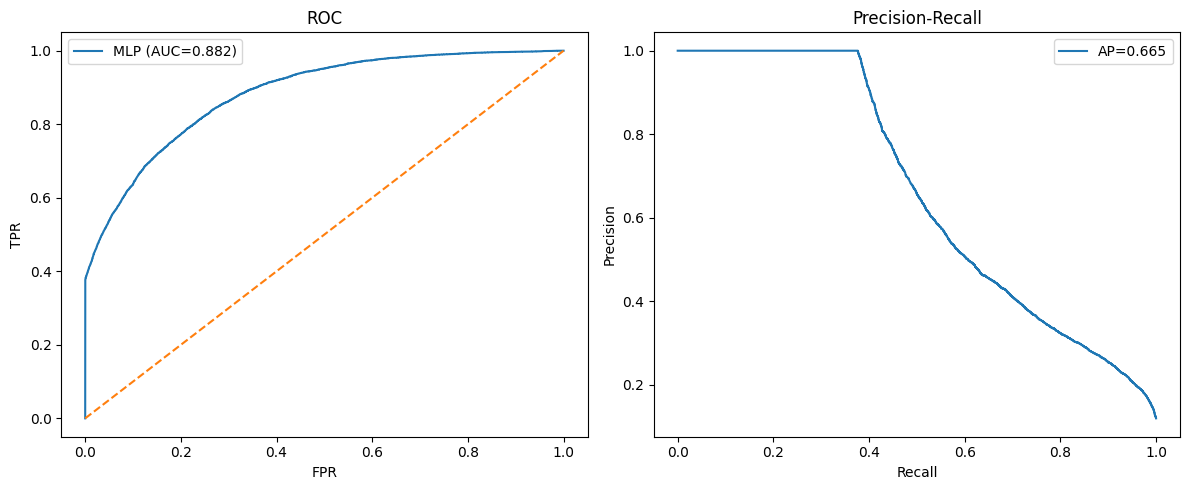

Saved ROC+PR -> mlp_roc_pr.png

Confusion matrix (TEST, best-F1 threshold):
[[55973  1518]
 [ 4085  3695]]


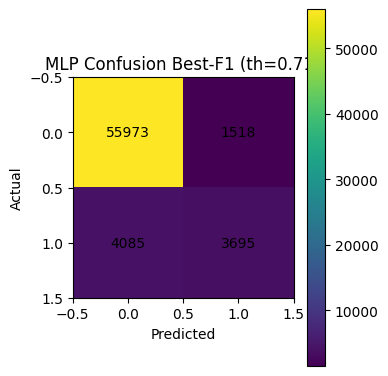


Confusion matrix (TEST, clinical threshold 0.48):
[[44066 13425]
 [ 1502  6278]]


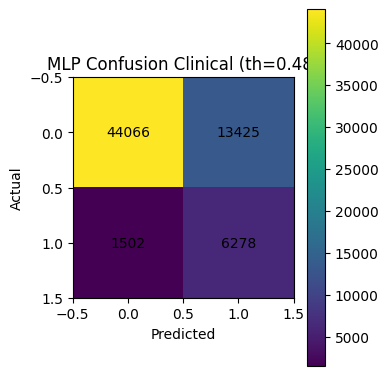

Saved confusion matrices: mlp_confusion_bestf1.png and mlp_confusion_clinical.png
Saved MLP model -> mlp_model.pt


In [11]:
# MLP pipeline for heart_disease_features.csv
# - Clean split, no data leakage
# - PyTorch MLP with class imbalance handling
# - Best-F1 threshold on validation, metrics on test
# - Plots + confusion matrices shown on screen

import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import joblib

# ------------------- CONFIG -------------------
DATA_PATH = "/content/heart_disease_features.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_RATIO_WITHIN_TRAIN = 0.10

BATCH_SIZE = 1024
MAX_EPOCHS = 30
LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 4  # early stopping on val AUC

HIDDEN_SIZES = [128, 64, 32]
DROPOUT = 0.2

RECOMMENDED_CLINICAL_THRESHOLD = 0.48

OUT_METRICS = "mlp_metrics.csv"
OUT_ROCPR = "mlp_roc_pr.png"
OUT_CM_F1 = "mlp_confusion_bestf1.png"
OUT_CM_CLIN = "mlp_confusion_clinical.png"
OUT_MODEL = "mlp_model.pt"
OUT_COLUMNS = "mlp_columns.json"
OUT_SCALER = "mlp_scaler.joblib"

# ------------------- 1. Reproducibility -------------------
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------- 2. Load data -------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print(df.dtypes)

print("\nTarget distribution:\n", df["HeartDisease"].value_counts(normalize=True))

target = "HeartDisease"
X = df.drop(columns=[target]).copy()
y = df[target].astype(int).copy()

# ------------------- 3. Basic preprocessing + FE -------------------
base_num_cols = [c for c in ["Age", "BMI"] if c in X.columns]
if len(base_num_cols) > 0:
    X[base_num_cols] = X[base_num_cols].fillna(X[base_num_cols].median())
for c in [c for c in X.columns if c not in base_num_cols]:
    X[c] = X[c].fillna(0)

def add_features(Xdf):
    Xc = Xdf.copy()
    if "Age" in Xc.columns:
        Xc["age_bin"] = pd.cut(Xc["Age"], bins=[17, 40, 55, 70, 120], labels=False).astype(int)
    if "BMI" in Xc.columns:
        Xc["BMI_obese"] = (Xc["BMI"] >= 30).astype(int)
    if "Age" in Xc.columns and "BMI" in Xc.columns:
        Xc["age_x_bmi"] = Xc["Age"] * Xc["BMI"]
    risk_cols = [
        c for c in ["Stroke", "HighBP", "HighChol", "Smoker",
                    "Diabetes", "Depression", "DiffWalk", "BMI_obese"]
        if c in Xc.columns
    ]
    Xc["risk_count"] = Xc[risk_cols].sum(axis=1) if len(risk_cols) > 0 else 0
    return Xc

X = add_features(X)

# ------------------- 4. Train/Val/Test split -------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_RATIO_WITHIN_TRAIN,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Shapes - train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ------------------- 5. Scaling (fit ONLY on train) -------------------
scaler = StandardScaler()
scaler.fit(X_train.values)  # fit on train only

X_train_scaled = scaler.transform(X_train.values)
X_val_scaled   = scaler.transform(X_val.values)
X_test_scaled  = scaler.transform(X_test.values)

cols = list(X_train.columns)
joblib.dump(scaler, OUT_SCALER)
json.dump(cols, open(OUT_COLUMNS, "w"))
print("Saved columns & scaler")

# ------------------- 6. Torch datasets & loaders -------------------
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

num_features = X_train_t.shape[1]
print("Number of features:", num_features)

# ------------------- 7. Define MLP model -------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))  # output logit
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)  # [batch]

model = MLP(num_features, HIDDEN_SIZES, DROPOUT).to(device)

# ------------------- 8. Loss, optimizer, pos_weight -------------------
# pos_weight = (num_neg / num_pos)
pos = y_train_t.sum().item()
neg = len(y_train_t) - pos
pos_weight_value = neg / max(pos, 1.0)
pos_weight = torch.tensor(pos_weight_value, device=device)
print(f"pos_weight for BCEWithLogitsLoss: {pos_weight_value:.3f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ------------------- 9. Evaluation helper -------------------
def eval_model(model, loader):
    model.eval()
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            all_logits.append(logits.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())
    all_logits = np.concatenate(all_logits)
    all_targets = np.concatenate(all_targets)
    probs = 1 / (1 + np.exp(-all_logits))  # sigmoid
    loss = criterion(
        torch.tensor(all_logits, dtype=torch.float32, device=device),
        torch.tensor(all_targets, dtype=torch.float32, device=device)
    ).item()
    try:
        auc_val = roc_auc_score(all_targets, probs)
    except ValueError:
        auc_val = np.nan
    return loss, auc_val, probs, all_targets

# ------------------- 10. Training loop with early stopping (val AUC) -------------------
best_val_auc = -np.inf
best_state = None
epochs_no_improve = 0

print("Training MLP...")
t0 = time.time()
for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss, val_auc, _, _ = eval_model(model, val_loader)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_auc={val_auc:.4f}")

    # early stopping
    if val_auc > best_val_auc + 1e-4:
        best_val_auc = val_auc
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no val AUC improvement for {PATIENCE} epochs).")
            break

print("Training finished in %.1f sec" % (time.time() - t0))

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model with val AUC = {best_val_auc:.4f}")

# ------------------- 11. Probabilities on VAL & TEST -------------------
val_loss, val_auc, prob_val, y_val_np = eval_model(model, val_loader)
test_loss, test_auc, prob_test, y_test_np = eval_model(model, test_loader)

print(f"Final VAL AUC:  {val_auc:.6f}")
print(f"Final TEST AUC: {test_auc:.6f}")

# ------------------- 12. Thresholds: best-F1 (VAL), Youden (VAL), clinical -------------------
ths = np.linspace(0.01, 0.99, 99)
rows_val = []
for t in ths:
    p_val = (prob_val >= t).astype(int)
    rows_val.append({
        "threshold": float(t),
        "precision": float(precision_score(y_val_np, p_val, zero_division=0)),
        "recall": float(recall_score(y_val_np, p_val, zero_division=0)),
        "f1": float(f1_score(y_val_np, p_val, zero_division=0)),
        "accuracy": float(accuracy_score(y_val_np, p_val))
    })
df_th_val = pd.DataFrame(rows_val)

best_f1_row = df_th_val.loc[df_th_val["f1"].idxmax()]
best_f1_t = float(best_f1_row["threshold"])

fpr_val, tpr_val, roc_ths_val = roc_curve(y_val_np, prob_val)
youden_idx = np.argmax(tpr_val - fpr_val)
youden_t = float(roc_ths_val[youden_idx])

clinical_t = float(RECOMMENDED_CLINICAL_THRESHOLD)

print("Thresholds found (from VALIDATION):")
print(" best-F1:", best_f1_t,
      "-> F1 (val):", best_f1_row["f1"],
      "prec (val):", best_f1_row["precision"],
      "rec (val):", best_f1_row["recall"])
print(" youden (val):", youden_t)
print(" recommended clinical:", clinical_t)

# ------------------- 13. Metrics on TEST -------------------
def metrics_at(y, probs, th):
    preds = (probs >= th).astype(int)
    return {
        "AUC": float(roc_auc_score(y, probs)),
        "Accuracy": float(accuracy_score(y, preds)),
        "Precision": float(precision_score(y, preds, zero_division=0)),
        "Recall": float(recall_score(y, preds)),
        "F1": float(f1_score(y, preds)),
        "Threshold": float(th)
    }

metrics_bestf1 = metrics_at(y_test_np, prob_test, best_f1_t)
metrics_clinical = metrics_at(y_test_np, prob_test, clinical_t)

final_df = pd.DataFrame(
    [metrics_bestf1, metrics_clinical],
    index=["best-F1", "clinical-0.48"]
).T

final_df.to_csv(OUT_METRICS)
print("\n=== TEST METRICS (MLP) ===")
print(final_df)

# ------------------- 14. ROC + PR plots -------------------
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test_np, prob_test)
plt.plot(fpr, tpr, label=f"MLP (AUC={roc_auc_score(y_test_np, prob_test):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

# PR
plt.subplot(1, 2, 2)
prec, rec, _ = precision_recall_curve(y_test_np, prob_test)
plt.plot(rec, prec, label=f"AP={auc(rec, prec):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.legend()

plt.tight_layout()
plt.savefig(OUT_ROCPR)
plt.show()
print("Saved ROC+PR ->", OUT_ROCPR)

# ------------------- 15. Confusion matrices -------------------
def save_cm(cm, fname, title):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

cm_best = confusion_matrix(y_test_np, (prob_test >= best_f1_t).astype(int))
cm_clin = confusion_matrix(y_test_np, (prob_test >= clinical_t).astype(int))

print("\nConfusion matrix (TEST, best-F1 threshold):")
print(cm_best)
save_cm(cm_best, OUT_CM_F1, f"MLP Confusion Best-F1 (th={best_f1_t:.2f})")

print("\nConfusion matrix (TEST, clinical threshold 0.48):")
print(cm_clin)
save_cm(cm_clin, OUT_CM_CLIN, f"MLP Confusion Clinical (th={clinical_t:.2f})")

print("Saved confusion matrices:", OUT_CM_F1, "and", OUT_CM_CLIN)

# ------------------- 16. Save model -------------------
torch.save(model.state_dict(), OUT_MODEL)
print("Saved MLP model ->", OUT_MODEL)


Loaded: /content/heart_disease_features.csv shape: (326353, 11)
HeartDisease      int64
Stroke          float64
Age             float64
Sex               int64
HighBP          float64
HighChol        float64
Smoker          float64
Diabetes        float64
Depression      float64
BMI             float64
DiffWalk        float64
dtype: object

Target distribution:
 HeartDisease
0    0.880801
1    0.119199
Name: proportion, dtype: float64
Shapes - train: (234973, 14) val: (26109, 14) test: (65271, 14)
Saved columns & scaler
Training KNN (actually fitting index)...
KNN 'training' finished in 1.0 sec
Computing probabilities on validation and test (this can be slow for KNN)...
Predictions done in 38.6 sec
Final VAL AUC:  0.809620
Final TEST AUC: 0.811180
Thresholds found (from VALIDATION):
 best-F1: 0.54 -> F1 (val): 0.5185342088540563 prec (val): 0.7607209446861405 rec (val): 0.39331619537275064
 youden (val): 0.11841069046408347
 recommended clinical: 0.48

=== TEST METRICS (KNN) ===
      

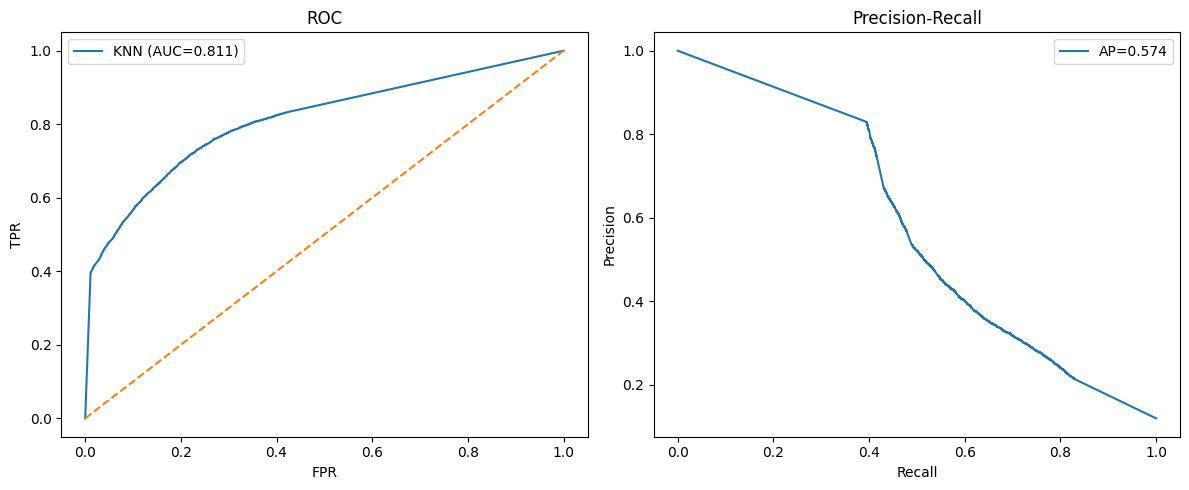

Saved ROC+PR -> knn_roc_pr.png

Confusion matrix (TEST, best-F1 threshold):
[[56473  1018]
 [ 4565  3215]]


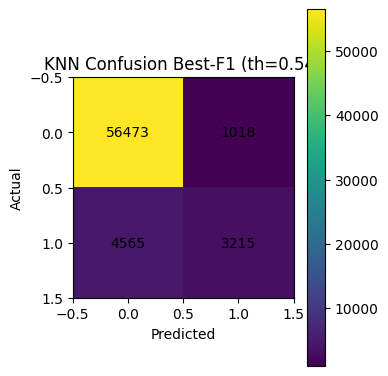


Confusion matrix (TEST, clinical threshold 0.48):
[[55807  1684]
 [ 4408  3372]]


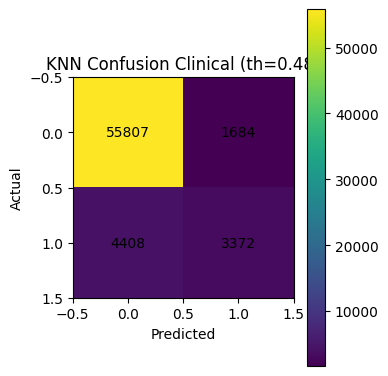

Saved confusion matrices: knn_confusion_bestf1.png and knn_confusion_clinical.png
Saved KNN model -> knn_model.joblib


In [12]:
# KNN pipeline for heart_disease_features.csv
# - Clean split, no data leakage
# - Sklearn KNN (with probabilities)
# - Best-F1 threshold on validation, metrics on test
# - Plots + confusion matrices shown on screen

import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)
from sklearn.neighbors import KNeighborsClassifier
import joblib

# ------------------- CONFIG -------------------
DATA_PATH = "/content/heart_disease_features.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_RATIO_WITHIN_TRAIN = 0.10

# KNN hyperparameters (you can tweak)
N_NEIGHBORS = 25
KNN_WEIGHTS = "distance"      # 'uniform' or 'distance'
KNN_METRIC = "minkowski"      # 'euclidean' etc.

RECOMMENDED_CLINICAL_THRESHOLD = 0.48

OUT_METRICS = "knn_metrics.csv"
OUT_ROCPR = "knn_roc_pr.png"
OUT_CM_F1 = "knn_confusion_bestf1.png"
OUT_CM_CLIN = "knn_confusion_clinical.png"
OUT_MODEL = "knn_model.joblib"
OUT_COLUMNS = "knn_columns.json"
OUT_SCALER = "knn_scaler.joblib"

np.random.seed(RANDOM_STATE)

# ------------------- 1. Load data -------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print(df.dtypes)

print("\nTarget distribution:\n", df["HeartDisease"].value_counts(normalize=True))

target = "HeartDisease"
X = df.drop(columns=[target]).copy()
y = df[target].astype(int).copy()

# ------------------- 2. Basic preprocessing + FE -------------------
base_num_cols = [c for c in ["Age", "BMI"] if c in X.columns]
if len(base_num_cols) > 0:
    X[base_num_cols] = X[base_num_cols].fillna(X[base_num_cols].median())
for c in [c for c in X.columns if c not in base_num_cols]:
    X[c] = X[c].fillna(0)

def add_features(Xdf):
    Xc = Xdf.copy()
    if "Age" in Xc.columns:
        Xc["age_bin"] = pd.cut(Xc["Age"], bins=[17, 40, 55, 70, 120],
                               labels=False).astype(int)
    if "BMI" in Xc.columns:
        Xc["BMI_obese"] = (Xc["BMI"] >= 30).astype(int)
    if "Age" in Xc.columns and "BMI" in Xc.columns:
        Xc["age_x_bmi"] = Xc["Age"] * Xc["BMI"]
    risk_cols = [
        c for c in ["Stroke", "HighBP", "HighChol", "Smoker",
                    "Diabetes", "Depression", "DiffWalk", "BMI_obese"]
        if c in Xc.columns
    ]
    Xc["risk_count"] = Xc[risk_cols].sum(axis=1) if len(risk_cols) > 0 else 0
    return Xc

X = add_features(X)

# ------------------- 3. Train/Val/Test split -------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_RATIO_WITHIN_TRAIN,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Shapes - train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ------------------- 4. Scaling (fit ONLY on train) -------------------
scaler = StandardScaler()
scaler.fit(X_train.values)  # fit on train only

X_train_scaled = scaler.transform(X_train.values)
X_val_scaled   = scaler.transform(X_val.values)
X_test_scaled  = scaler.transform(X_test.values)

cols = list(X_train.columns)
joblib.dump(scaler, OUT_SCALER)
json.dump(cols, open(OUT_COLUMNS, "w"))
print("Saved columns & scaler")

# ------------------- 5. KNN model -------------------
knn = KNeighborsClassifier(
    n_neighbors=N_NEIGHBORS,
    weights=KNN_WEIGHTS,
    metric=KNN_METRIC,
    n_jobs=-1
)

print("Training KNN (actually fitting index)...")
t0 = time.time()
knn.fit(X_train_scaled, y_train.values)
print("KNN 'training' finished in %.1f sec" % (time.time() - t0))

# ------------------- 6. Probabilities on VAL & TEST -------------------
print("Computing probabilities on validation and test (this can be slow for KNN)...")
t1 = time.time()
prob_val = knn.predict_proba(X_val_scaled)[:, 1]
prob_test = knn.predict_proba(X_test_scaled)[:, 1]
print("Predictions done in %.1f sec" % (time.time() - t1))

val_auc = roc_auc_score(y_val, prob_val)
test_auc = roc_auc_score(y_test, prob_test)
print(f"Final VAL AUC:  {val_auc:.6f}")
print(f"Final TEST AUC: {test_auc:.6f}")

# ------------------- 7. Thresholds: best-F1 (VAL), Youden (VAL), clinical -------------------
ths = np.linspace(0.01, 0.99, 99)
rows_val = []
for t in ths:
    p_val = (prob_val >= t).astype(int)
    rows_val.append({
        "threshold": float(t),
        "precision": float(precision_score(y_val, p_val, zero_division=0)),
        "recall": float(recall_score(y_val, p_val, zero_division=0)),
        "f1": float(f1_score(y_val, p_val, zero_division=0)),
        "accuracy": float(accuracy_score(y_val, p_val))
    })
df_th_val = pd.DataFrame(rows_val)

best_f1_row = df_th_val.loc[df_th_val["f1"].idxmax()]
best_f1_t = float(best_f1_row["threshold"])

fpr_val, tpr_val, roc_ths_val = roc_curve(y_val, prob_val)
youden_idx = np.argmax(tpr_val - fpr_val)
youden_t = float(roc_ths_val[youden_idx])

clinical_t = float(RECOMMENDED_CLINICAL_THRESHOLD)

print("Thresholds found (from VALIDATION):")
print(" best-F1:", best_f1_t,
      "-> F1 (val):", best_f1_row["f1"],
      "prec (val):", best_f1_row["precision"],
      "rec (val):", best_f1_row["recall"])
print(" youden (val):", youden_t)
print(" recommended clinical:", clinical_t)

# ------------------- 8. Metrics on TEST -------------------
def metrics_at(y, probs, th):
    preds = (probs >= th).astype(int)
    return {
        "AUC": float(roc_auc_score(y, probs)),
        "Accuracy": float(accuracy_score(y, preds)),
        "Precision": float(precision_score(y, preds, zero_division=0)),
        "Recall": float(recall_score(y, preds)),
        "F1": float(f1_score(y, preds)),
        "Threshold": float(th)
    }

y_test_np = y_test.values

metrics_bestf1 = metrics_at(y_test_np, prob_test, best_f1_t)
metrics_clinical = metrics_at(y_test_np, prob_test, clinical_t)

final_df = pd.DataFrame(
    [metrics_bestf1, metrics_clinical],
    index=["best-F1", "clinical-0.48"]
).T

final_df.to_csv(OUT_METRICS)
print("\n=== TEST METRICS (KNN) ===")
print(final_df)

# ------------------- 9. ROC + PR plots -------------------
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test_np, prob_test)
plt.plot(fpr, tpr, label=f"KNN (AUC={roc_auc_score(y_test_np, prob_test):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

# PR
plt.subplot(1, 2, 2)
prec, rec, _ = precision_recall_curve(y_test_np, prob_test)
plt.plot(rec, prec, label=f"AP={auc(rec, prec):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.legend()

plt.tight_layout()
plt.savefig(OUT_ROCPR)
plt.show()
print("Saved ROC+PR ->", OUT_ROCPR)

# ------------------- 10. Confusion matrices -------------------
def save_cm(cm, fname, title):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

cm_best = confusion_matrix(y_test_np, (prob_test >= best_f1_t).astype(int))
cm_clin = confusion_matrix(y_test_np, (prob_test >= clinical_t).astype(int))

print("\nConfusion matrix (TEST, best-F1 threshold):")
print(cm_best)
save_cm(cm_best, OUT_CM_F1, f"KNN Confusion Best-F1 (th={best_f1_t:.2f})")

print("\nConfusion matrix (TEST, clinical threshold 0.48):")
print(cm_clin)
save_cm(cm_clin, OUT_CM_CLIN, f"KNN Confusion Clinical (th={clinical_t:.2f})")

print("Saved confusion matrices:", OUT_CM_F1, "and", OUT_CM_CLIN)

# ------------------- 11. Save model -------------------
joblib.dump(knn, OUT_MODEL)
print("Saved KNN model ->", OUT_MODEL)


Using device: cuda
Loaded: /content/heart_disease_features.csv shape: (326353, 11)
HeartDisease      int64
Stroke          float64
Age             float64
Sex               int64
HighBP          float64
HighChol        float64
Smoker          float64
Diabetes        float64
Depression      float64
BMI             float64
DiffWalk        float64
dtype: object

Target distribution:
 HeartDisease
0    0.880801
1    0.119199
Name: proportion, dtype: float64
Shapes - train: (234973, 14) val: (26109, 14) test: (65271, 14)
Saved columns & scaler
Number of features: 14
pos_weight for BCEWithLogitsLoss: 7.389
Training SAINT-style model...
Epoch 01 | train_loss=0.7684 | val_loss=0.7355 | val_auc=0.8812
Epoch 02 | train_loss=0.7399 | val_loss=0.7350 | val_auc=0.8826
Epoch 03 | train_loss=0.7376 | val_loss=0.7368 | val_auc=0.8823
Epoch 04 | train_loss=0.7377 | val_loss=0.7338 | val_auc=0.8814
Epoch 05 | train_loss=0.7357 | val_loss=0.7376 | val_auc=0.8820
Early stopping at epoch 5 (no val AUC impr

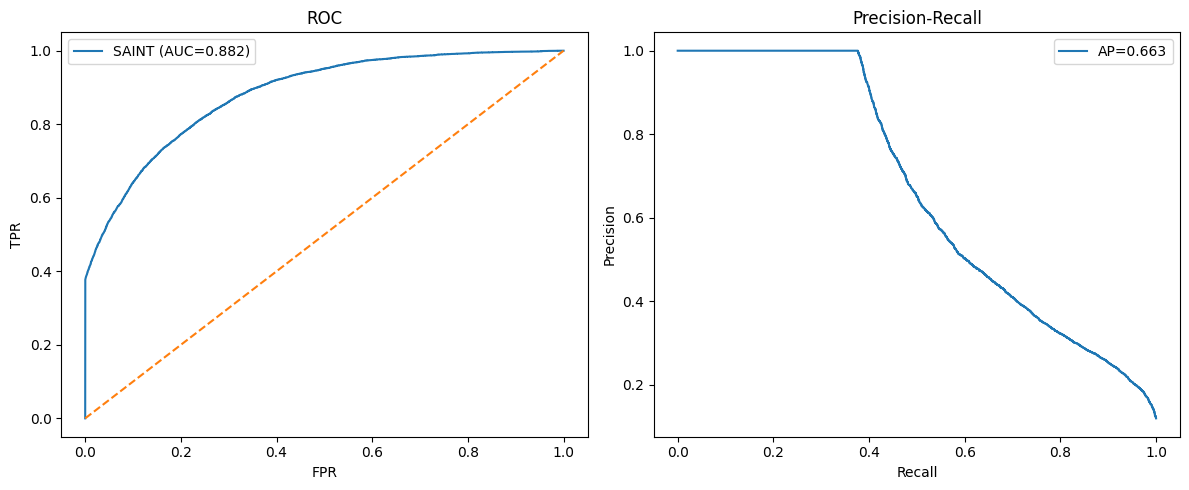

Saved ROC+PR -> saint_roc_pr.png

Confusion matrix (TEST, best-F1 threshold):
[[56469  1022]
 [ 4338  3442]]


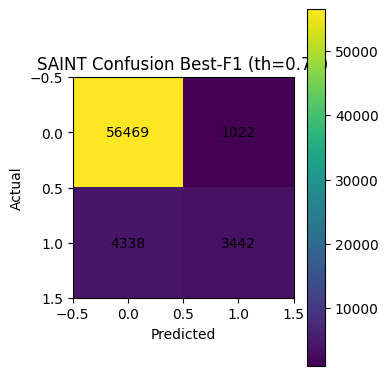


Confusion matrix (TEST, clinical threshold 0.48):
[[45386 12105]
 [ 1690  6090]]


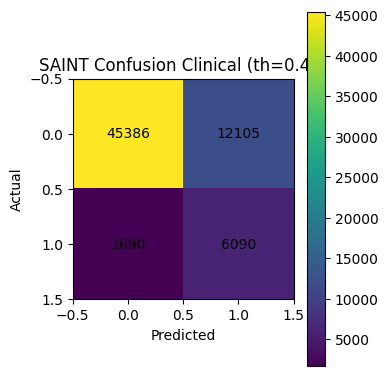

Saved confusion matrices: saint_confusion_bestf1.png and saint_confusion_clinical.png
Saved SAINT-style model -> saint_model.pt


In [13]:
# SAINT-style Transformer pipeline for heart_disease_features.csv
# - Clean split, no leakage
# - SAINT-like tabular transformer (column embeddings + value projection)
# - Class imbalance handled with pos_weight
# - Best-F1 threshold from validation, metrics on test
# - ROC/PR plots + confusion matrices shown on screen

import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import joblib

# ------------------- CONFIG -------------------
DATA_PATH = "/content/heart_disease_features.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_RATIO_WITHIN_TRAIN = 0.10

BATCH_SIZE = 1024
MAX_EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 3  # early stopping on val AUC

D_TOKEN = 64
N_LAYERS = 3
N_HEADS = 4
DROPOUT = 0.1

RECOMMENDED_CLINICAL_THRESHOLD = 0.48

OUT_METRICS = "saint_metrics.csv"
OUT_ROCPR = "saint_roc_pr.png"
OUT_CM_F1 = "saint_confusion_bestf1.png"
OUT_CM_CLIN = "saint_confusion_clinical.png"
OUT_MODEL = "saint_model.pt"
OUT_COLUMNS = "saint_columns.json"
OUT_SCALER = "saint_scaler.joblib"

# ------------------- 1. Reproducibility & device -------------------
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------- 2. Load data -------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print(df.dtypes)

print("\nTarget distribution:\n", df["HeartDisease"].value_counts(normalize=True))

target = "HeartDisease"
X = df.drop(columns=[target]).copy()
y = df[target].astype(int).copy()

# ------------------- 3. Basic preprocessing + FE -------------------
base_num_cols = [c for c in ["Age", "BMI"] if c in X.columns]
if len(base_num_cols) > 0:
    X[base_num_cols] = X[base_num_cols].fillna(X[base_num_cols].median())
for c in [c for c in X.columns if c not in base_num_cols]:
    X[c] = X[c].fillna(0)

def add_features(Xdf):
    Xc = Xdf.copy()
    if "Age" in Xc.columns:
        Xc["age_bin"] = pd.cut(Xc["Age"], bins=[17, 40, 55, 70, 120], labels=False).astype(int)
    if "BMI" in Xc.columns:
        Xc["BMI_obese"] = (Xc["BMI"] >= 30).astype(int)
    if "Age" in Xc.columns and "BMI" in Xc.columns:
        Xc["age_x_bmi"] = Xc["Age"] * Xc["BMI"]
    risk_cols = [
        c for c in ["Stroke", "HighBP", "HighChol", "Smoker",
                    "Diabetes", "Depression", "DiffWalk", "BMI_obese"]
        if c in Xc.columns
    ]
    Xc["risk_count"] = Xc[risk_cols].sum(axis=1) if len(risk_cols) > 0 else 0
    return Xc

X = add_features(X)

# ------------------- 4. Train/Val/Test split -------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_RATIO_WITHIN_TRAIN,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Shapes - train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ------------------- 5. Scaling (fit ONLY on train) -------------------
scaler = StandardScaler()
scaler.fit(X_train.values)  # fit on train only

X_train_scaled = scaler.transform(X_train.values)
X_val_scaled   = scaler.transform(X_val.values)
X_test_scaled  = scaler.transform(X_test.values)

cols = list(X_train.columns)
joblib.dump(scaler, OUT_SCALER)
json.dump(cols, open(OUT_COLUMNS, "w"))
print("Saved columns & scaler")

# ------------------- 6. Torch datasets & loaders -------------------
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

num_features = X_train_t.shape[1]
print("Number of features:", num_features)

# ------------------- 7. SAINT-style model -------------------
class SAINT(nn.Module):
    """
    SAINT-style tabular transformer:
    - Each feature becomes a token: value projected to d_token + column embedding
    - Apply Transformer encoder over feature dimension
    - Mean-pool tokens -> head -> logit
    """
    def __init__(self, num_features, d_token=64, n_heads=4, n_layers=3, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.d_token = d_token

        # Column embeddings (which feature)
        self.col_embed = nn.Embedding(num_features, d_token)

        # Shared linear to embed continuous value
        self.val_proj = nn.Linear(1, d_token)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=4 * d_token,
            dropout=dropout,
            activation="gelu",
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.norm = nn.LayerNorm(d_token)
        self.head = nn.Linear(d_token, 1)

    def forward(self, x):
        # x: [batch, num_features] (scaled real values)
        B, F = x.shape

        # value projection: [B, F, 1] -> [B, F, d_token]
        x_val = x.unsqueeze(-1)                 # [B, F, 1]
        val_emb = self.val_proj(x_val)          # [B, F, d_token]

        # column embeddings
        col_idx = torch.arange(F, device=x.device).unsqueeze(0).expand(B, -1)  # [B, F]
        col_emb = self.col_embed(col_idx)                                      # [B, F, d_token]

        # tokens = value embedding + column embedding
        tokens = val_emb + col_emb                                             # [B, F, d_token]

        # transformer encoder
        h = self.encoder(tokens)                                               # [B, F, d_token]

        # SAINT paper can use CLS or pooling; here we use mean pooling
        h_pool = h.mean(dim=1)                                                 # [B, d_token]

        h_norm = self.norm(h_pool)
        logit = self.head(h_norm).squeeze(-1)                                  # [B]
        return logit

model = SAINT(
    num_features=num_features,
    d_token=D_TOKEN,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

# ------------------- 8. Loss, optimizer, pos_weight -------------------
pos = y_train_t.sum().item()
neg = len(y_train_t) - pos
pos_weight_value = neg / max(pos, 1.0)
pos_weight = torch.tensor(pos_weight_value, device=device)
print(f"pos_weight for BCEWithLogitsLoss: {pos_weight_value:.3f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ------------------- 9. Evaluation helper -------------------
def eval_model(model, loader):
    model.eval()
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            all_logits.append(logits.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())
    all_logits = np.concatenate(all_logits)
    all_targets = np.concatenate(all_targets)
    probs = 1 / (1 + np.exp(-all_logits))  # sigmoid
    loss = criterion(
        torch.tensor(all_logits, dtype=torch.float32, device=device),
        torch.tensor(all_targets, dtype=torch.float32, device=device)
    ).item()
    try:
        auc_val = roc_auc_score(all_targets, probs)
    except ValueError:
        auc_val = np.nan
    return loss, auc_val, probs, all_targets

# ------------------- 10. Training loop with early stopping (val AUC) -------------------
best_val_auc = -np.inf
best_state = None
epochs_no_improve = 0

print("Training SAINT-style model...")
t0 = time.time()
for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss, val_auc, _, _ = eval_model(model, val_loader)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_auc={val_auc:.4f}")

    if val_auc > best_val_auc + 1e-4:
        best_val_auc = val_auc
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no val AUC improvement for {PATIENCE} epochs).")
            break

print("Training finished in %.1f sec" % (time.time() - t0))

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model with val AUC = {best_val_auc:.4f}")

# ------------------- 11. Probabilities on VAL & TEST -------------------
val_loss, val_auc, prob_val, y_val_np = eval_model(model, val_loader)
test_loss, test_auc, prob_test, y_test_np = eval_model(model, test_loader)

print(f"Final VAL AUC:  {val_auc:.6f}")
print(f"Final TEST AUC: {test_auc:.6f}")

# ------------------- 12. Thresholds: best-F1 (VAL), Youden (VAL), clinical -------------------
ths = np.linspace(0.01, 0.99, 99)
rows_val = []
for t in ths:
    p_val = (prob_val >= t).astype(int)
    rows_val.append({
        "threshold": float(t),
        "precision": float(precision_score(y_val_np, p_val, zero_division=0)),
        "recall": float(recall_score(y_val_np, p_val, zero_division=0)),
        "f1": float(f1_score(y_val_np, p_val, zero_division=0)),
        "accuracy": float(accuracy_score(y_val_np, p_val))
    })
df_th_val = pd.DataFrame(rows_val)

best_f1_row = df_th_val.loc[df_th_val["f1"].idxmax()]
best_f1_t = float(best_f1_row["threshold"])

fpr_val, tpr_val, roc_ths_val = roc_curve(y_val_np, prob_val)
youden_idx = np.argmax(tpr_val - fpr_val)
youden_t = float(roc_ths_val[youden_idx])

clinical_t = float(RECOMMENDED_CLINICAL_THRESHOLD)

print("Thresholds found (from VALIDATION):")
print(" best-F1:", best_f1_t,
      "-> F1 (val):", best_f1_row["f1"],
      "prec (val):", best_f1_row["precision"],
      "rec (val):", best_f1_row["recall"])
print(" youden (val):", youden_t)
print(" recommended clinical:", clinical_t)

# ------------------- 13. Metrics on TEST -------------------
def metrics_at(y, probs, th):
    preds = (probs >= th).astype(int)
    return {
        "AUC": float(roc_auc_score(y, probs)),
        "Accuracy": float(accuracy_score(y, preds)),
        "Precision": float(precision_score(y, preds, zero_division=0)),
        "Recall": float(recall_score(y, preds)),
        "F1": float(f1_score(y, preds)),
        "Threshold": float(th)
    }

metrics_bestf1 = metrics_at(y_test_np, prob_test, best_f1_t)
metrics_clinical = metrics_at(y_test_np, prob_test, clinical_t)

final_df = pd.DataFrame(
    [metrics_bestf1, metrics_clinical],
    index=["best-F1", "clinical-0.48"]
).T

final_df.to_csv(OUT_METRICS)
print("\n=== TEST METRICS (SAINT-style) ===")
print(final_df)

# ------------------- 14. ROC + PR plots -------------------
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test_np, prob_test)
plt.plot(fpr, tpr, label=f"SAINT (AUC={roc_auc_score(y_test_np, prob_test):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

# PR
plt.subplot(1, 2, 2)
prec, rec, _ = precision_recall_curve(y_test_np, prob_test)
plt.plot(rec, prec, label=f"AP={auc(rec, prec):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.legend()

plt.tight_layout()
plt.savefig(OUT_ROCPR)
plt.show()
print("Saved ROC+PR ->", OUT_ROCPR)

# ------------------- 15. Confusion matrices -------------------
def save_cm(cm, fname, title):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

cm_best = confusion_matrix(y_test_np, (prob_test >= best_f1_t).astype(int))
cm_clin = confusion_matrix(y_test_np, (prob_test >= clinical_t).astype(int))

print("\nConfusion matrix (TEST, best-F1 threshold):")
print(cm_best)
save_cm(cm_best, OUT_CM_F1, f"SAINT Confusion Best-F1 (th={best_f1_t:.2f})")

print("\nConfusion matrix (TEST, clinical threshold 0.48):")
print(cm_clin)
save_cm(cm_clin, OUT_CM_CLIN, f"SAINT Confusion Clinical (th={clinical_t:.2f})")

print("Saved confusion matrices:", OUT_CM_F1, "and", OUT_CM_CLIN)

# ------------------- 16. Save model -------------------
torch.save(model.state_dict(), OUT_MODEL)
print("Saved SAINT-style model ->", OUT_MODEL)


Using device: cuda
Loaded: /content/heart_disease_features.csv shape: (326353, 11)
HeartDisease      int64
Stroke          float64
Age             float64
Sex               int64
HighBP          float64
HighChol        float64
Smoker          float64
Diabetes        float64
Depression      float64
BMI             float64
DiffWalk        float64
dtype: object

Target distribution:
 HeartDisease
0    0.880801
1    0.119199
Name: proportion, dtype: float64
Shapes - train: (234973, 14) val: (26109, 14) test: (65271, 14)
Saved columns & scaler
Number of features: 14
pos_weight for BCEWithLogitsLoss: 7.389
Training ResNet-style MLP...
Epoch 01 | train_loss=0.7565 | val_loss=0.7337 | val_auc=0.8816
Epoch 02 | train_loss=0.7394 | val_loss=0.7349 | val_auc=0.8818
Epoch 03 | train_loss=0.7378 | val_loss=0.7331 | val_auc=0.8827
Epoch 04 | train_loss=0.7359 | val_loss=0.7368 | val_auc=0.8821
Epoch 05 | train_loss=0.7344 | val_loss=0.7426 | val_auc=0.8825
Epoch 06 | train_loss=0.7343 | val_loss=0.7

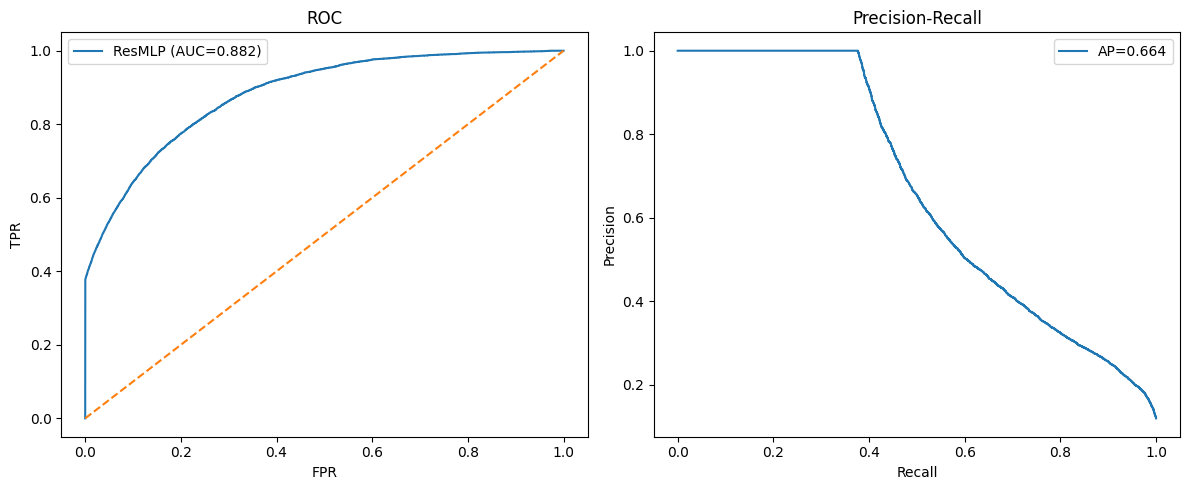

Saved ROC+PR -> resmlp_roc_pr.png

Confusion matrix (TEST, best-F1 threshold):
[[56159  1332]
 [ 4178  3602]]


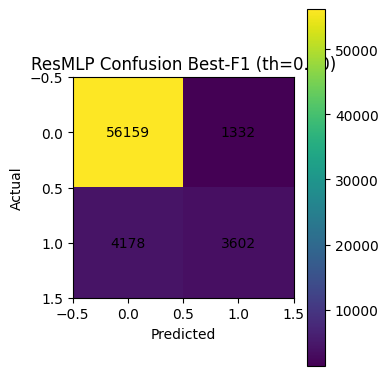


Confusion matrix (TEST, clinical threshold 0.48):
[[45650 11841]
 [ 1717  6063]]


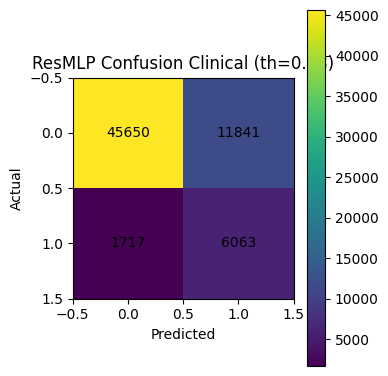

Saved confusion matrices: resmlp_confusion_bestf1.png and resmlp_confusion_clinical.png
Saved ResNet-style MLP model -> resmlp_model.pt


In [14]:
# ResNet-style MLP pipeline for heart_disease_features.csv
# - Clean split, no data leakage
# - ResNet-like MLP with residual blocks
# - Class imbalance handled with pos_weight
# - Best-F1 threshold from validation, metrics on test
# - ROC/PR plots + confusion matrices shown on screen

import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import joblib

# ------------------- CONFIG -------------------
DATA_PATH = "/content/heart_disease_features.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_RATIO_WITHIN_TRAIN = 0.10

BATCH_SIZE = 1024
MAX_EPOCHS = 30
LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 4  # early stopping on val AUC

HIDDEN_SIZE = 128        # base width
N_RES_BLOCKS = 4         # number of residual blocks
DROPOUT = 0.2

RECOMMENDED_CLINICAL_THRESHOLD = 0.48

OUT_METRICS = "resmlp_metrics.csv"
OUT_ROCPR = "resmlp_roc_pr.png"
OUT_CM_F1 = "resmlp_confusion_bestf1.png"
OUT_CM_CLIN = "resmlp_confusion_clinical.png"
OUT_MODEL = "resmlp_model.pt"
OUT_COLUMNS = "resmlp_columns.json"
OUT_SCALER = "resmlp_scaler.joblib"

# ------------------- 1. Reproducibility -------------------
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------- 2. Load data -------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print(df.dtypes)

print("\nTarget distribution:\n", df["HeartDisease"].value_counts(normalize=True))

target = "HeartDisease"
X = df.drop(columns=[target]).copy()
y = df[target].astype(int).copy()

# ------------------- 3. Basic preprocessing + FE -------------------
base_num_cols = [c for c in ["Age", "BMI"] if c in X.columns]
if len(base_num_cols) > 0:
    X[base_num_cols] = X[base_num_cols].fillna(X[base_num_cols].median())
for c in [c for c in X.columns if c not in base_num_cols]:
    X[c] = X[c].fillna(0)

def add_features(Xdf):
    Xc = Xdf.copy()
    if "Age" in Xc.columns:
        Xc["age_bin"] = pd.cut(Xc["Age"], bins=[17, 40, 55, 70, 120], labels=False).astype(int)
    if "BMI" in Xc.columns:
        Xc["BMI_obese"] = (Xc["BMI"] >= 30).astype(int)
    if "Age" in Xc.columns and "BMI" in Xc.columns:
        Xc["age_x_bmi"] = Xc["Age"] * Xc["BMI"]
    risk_cols = [
        c for c in ["Stroke", "HighBP", "HighChol", "Smoker",
                    "Diabetes", "Depression", "DiffWalk", "BMI_obese"]
        if c in Xc.columns
    ]
    Xc["risk_count"] = Xc[risk_cols].sum(axis=1) if len(risk_cols) > 0 else 0
    return Xc

X = add_features(X)

# ------------------- 4. Train/Val/Test split -------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_RATIO_WITHIN_TRAIN,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Shapes - train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ------------------- 5. Scaling (fit ONLY on train) -------------------
scaler = StandardScaler()
scaler.fit(X_train.values)  # fit on train only

X_train_scaled = scaler.transform(X_train.values)
X_val_scaled   = scaler.transform(X_val.values)
X_test_scaled  = scaler.transform(X_test.values)

cols = list(X_train.columns)
joblib.dump(scaler, OUT_SCALER)
json.dump(cols, open(OUT_COLUMNS, "w"))
print("Saved columns & scaler")

# ------------------- 6. Torch datasets & loaders -------------------
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

num_features = X_train_t.shape[1]
print("Number of features:", num_features)

# ------------------- 7. ResNet-style MLP model -------------------
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.2):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(dim)
        self.act1 = nn.ReLU()
        self.fc1 = nn.Linear(dim, dim)

        self.bn2 = nn.BatchNorm1d(dim)
        self.act2 = nn.ReLU()
        self.fc2 = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [batch, dim]
        residual = x
        out = self.bn1(x)
        out = self.act1(out)
        out = self.fc1(out)

        out = self.bn2(out)
        out = self.act2(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return residual + out  # residual connection

class ResNetMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, n_blocks=4, dropout=0.2):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout=dropout)
            for _ in range(n_blocks)
        ])

        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch, input_dim]
        out = self.input_layer(x)
        for block in self.blocks:
            out = block(out)  # each block adds a residual
        logits = self.output_layer(out).squeeze(-1)  # [batch]
        return logits

model = ResNetMLP(
    input_dim=num_features,
    hidden_dim=HIDDEN_SIZE,
    n_blocks=N_RES_BLOCKS,
    dropout=DROPOUT
).to(device)

# ------------------- 8. Loss, optimizer, pos_weight -------------------
pos = y_train_t.sum().item()
neg = len(y_train_t) - pos
pos_weight_value = neg / max(pos, 1.0)
pos_weight = torch.tensor(pos_weight_value, device=device)
print(f"pos_weight for BCEWithLogitsLoss: {pos_weight_value:.3f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# ------------------- 9. Evaluation helper -------------------
def eval_model(model, loader):
    model.eval()
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            all_logits.append(logits.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())
    all_logits = np.concatenate(all_logits)
    all_targets = np.concatenate(all_targets)
    probs = 1 / (1 + np.exp(-all_logits))  # sigmoid
    loss = criterion(
        torch.tensor(all_logits, dtype=torch.float32, device=device),
        torch.tensor(all_targets, dtype=torch.float32, device=device)
    ).item()
    try:
        auc_val = roc_auc_score(all_targets, probs)
    except ValueError:
        auc_val = np.nan
    return loss, auc_val, probs, all_targets

# ------------------- 10. Training loop with early stopping (val AUC) -------------------
best_val_auc = -np.inf
best_state = None
epochs_no_improve = 0

print("Training ResNet-style MLP...")
t0 = time.time()
for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss, val_auc, _, _ = eval_model(model, val_loader)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_auc={val_auc:.4f}")

    if val_auc > best_val_auc + 1e-4:
        best_val_auc = val_auc
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no val AUC improvement for {PATIENCE} epochs).")
            break

print("Training finished in %.1f sec" % (time.time() - t0))

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model with val AUC = {best_val_auc:.4f}")

# ------------------- 11. Probabilities on VAL & TEST -------------------
val_loss, val_auc, prob_val, y_val_np = eval_model(model, val_loader)
test_loss, test_auc, prob_test, y_test_np = eval_model(model, test_loader)

print(f"Final VAL AUC:  {val_auc:.6f}")
print(f"Final TEST AUC: {test_auc:.6f}")

# ------------------- 12. Thresholds: best-F1 (VAL), Youden (VAL), clinical -------------------
ths = np.linspace(0.01, 0.99, 99)
rows_val = []
for t in ths:
    p_val = (prob_val >= t).astype(int)
    rows_val.append({
        "threshold": float(t),
        "precision": float(precision_score(y_val_np, p_val, zero_division=0)),
        "recall": float(recall_score(y_val_np, p_val, zero_division=0)),
        "f1": float(f1_score(y_val_np, p_val, zero_division=0)),
        "accuracy": float(accuracy_score(y_val_np, p_val))
    })
df_th_val = pd.DataFrame(rows_val)

best_f1_row = df_th_val.loc[df_th_val["f1"].idxmax()]
best_f1_t = float(best_f1_row["threshold"])

fpr_val, tpr_val, roc_ths_val = roc_curve(y_val_np, prob_val)
youden_idx = np.argmax(tpr_val - fpr_val)
youden_t = float(roc_ths_val[youden_idx])

clinical_t = float(RECOMMENDED_CLINICAL_THRESHOLD)

print("Thresholds found (from VALIDATION):")
print(" best-F1:", best_f1_t,
      "-> F1 (val):", best_f1_row["f1"],
      "prec (val):", best_f1_row["precision"],
      "rec (val):", best_f1_row["recall"])
print(" youden (val):", youden_t)
print(" recommended clinical:", clinical_t)

# ------------------- 13. Metrics on TEST -------------------
def metrics_at(y, probs, th):
    preds = (probs >= th).astype(int)
    return {
        "AUC": float(roc_auc_score(y, probs)),
        "Accuracy": float(accuracy_score(y, preds)),
        "Precision": float(precision_score(y, preds, zero_division=0)),
        "Recall": float(recall_score(y, preds)),
        "F1": float(f1_score(y, preds)),
        "Threshold": float(th)
    }

metrics_bestf1 = metrics_at(y_test_np, prob_test, best_f1_t)
metrics_clinical = metrics_at(y_test_np, prob_test, clinical_t)

final_df = pd.DataFrame(
    [metrics_bestf1, metrics_clinical],
    index=["best-F1", "clinical-0.48"]
).T

final_df.to_csv(OUT_METRICS)
print("\n=== TEST METRICS (ResNet-style MLP) ===")
print(final_df)

# ------------------- 14. ROC + PR plots -------------------
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test_np, prob_test)
plt.plot(fpr, tpr, label=f"ResMLP (AUC={roc_auc_score(y_test_np, prob_test):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

# PR
plt.subplot(1, 2, 2)
prec, rec, _ = precision_recall_curve(y_test_np, prob_test)
plt.plot(rec, prec, label=f"AP={auc(rec, prec):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.legend()

plt.tight_layout()
plt.savefig(OUT_ROCPR)
plt.show()
print("Saved ROC+PR ->", OUT_ROCPR)

# ------------------- 15. Confusion matrices -------------------
def save_cm(cm, fname, title):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

cm_best = confusion_matrix(y_test_np, (prob_test >= best_f1_t).astype(int))
cm_clin = confusion_matrix(y_test_np, (prob_test >= clinical_t).astype(int))

print("\nConfusion matrix (TEST, best-F1 threshold):")
print(cm_best)
save_cm(cm_best, OUT_CM_F1, f"ResMLP Confusion Best-F1 (th={best_f1_t:.2f})")

print("\nConfusion matrix (TEST, clinical threshold 0.48):")
print(cm_clin)
save_cm(cm_clin, OUT_CM_CLIN, f"ResMLP Confusion Clinical (th={clinical_t:.2f})")

print("Saved confusion matrices:", OUT_CM_F1, "and", OUT_CM_CLIN)

# ------------------- 16. Save model -------------------
torch.save(model.state_dict(), OUT_MODEL)
print("Saved ResNet-style MLP model ->", OUT_MODEL)


Using device: cuda
Loaded: /content/heart_disease_features.csv shape: (326353, 11)
HeartDisease      int64
Stroke          float64
Age             float64
Sex               int64
HighBP          float64
HighChol        float64
Smoker          float64
Diabetes        float64
Depression      float64
BMI             float64
DiffWalk        float64
dtype: object

Target distribution:
 HeartDisease
0    0.880801
1    0.119199
Name: proportion, dtype: float64
Shapes - train: (234973, 14) val: (26109, 14) test: (65271, 14)
Saved columns & scaler
Class weights: {0: 0.5676663574341432, 1: 4.1945981648755755}
pos_weight for FT-Transformer BCEWithLogitsLoss: 7.389

Training LightGBM...
[LightGBM] [Info] Number of positive: 28009, number of negative: 206964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM VAL AUC:  0.882403
LightGBM TEST AUC: 0.882590

Number of features: 14

Training FT-Transformer...
Epoch 01 | train_loss=0.7612 | val_loss=0.7427 | val_auc=0.8818
Epoch 02 | train_loss=0.7413 | val_loss=0.7380 | val_auc=0.8819
Epoch 03 | train_loss=0.7406 | val_loss=0.7374 | val_auc=0.8823
Epoch 04 | train_loss=0.7394 | val_loss=0.7335 | val_auc=0.8820
Epoch 05 | train_loss=0.7375 | val_loss=0.7307 | val_auc=0.8828
Epoch 06 | train_loss=0.7369 | val_loss=0.7325 | val_auc=0.8826
Epoch 07 | train_loss=0.7347 | val_loss=0.7348 | val_auc=0.8820
Epoch 08 | train_loss=0.7355 | val_loss=0.7354 | val_auc=0.8817
Early stopping FT-Transformer at epoch 8 (no val AUC improvement for 3 epochs).
FT-Transformer training finished in 62.8 sec
Loaded best FT-Transformer model with val AUC = 0.8828
FT-Transformer VAL AUC:  0.881678
FT-Transformer TEST AUC: 0.881531

Ensemble FT-Transformer + LightGBM:
Ensemble VAL AUC:  0.882378
Ensemble TEST AUC: 0.882461
Thresholds found for ENSEMBLE (from VAL

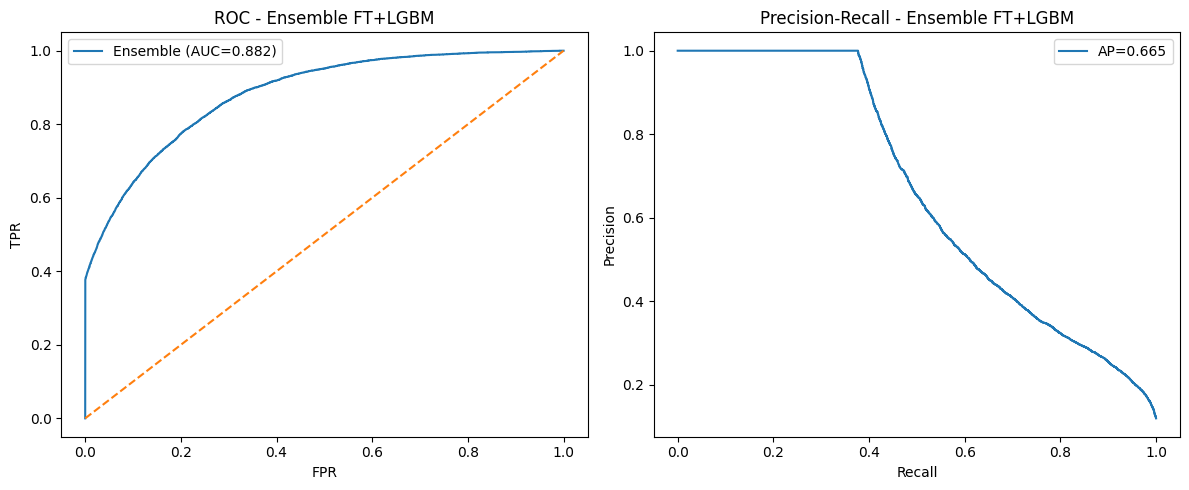

Saved ROC+PR -> ensemble_ft_lgbm_roc_pr.png

Confusion matrix (TEST, ENSEMBLE best-F1 threshold):
[[56668   823]
 [ 4411  3369]]


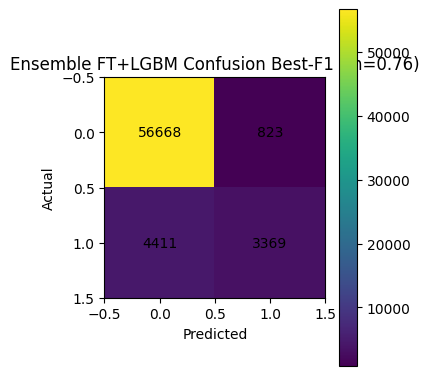


Confusion matrix (TEST, ENSEMBLE clinical threshold 0.48):
[[43411 14080]
 [ 1418  6362]]


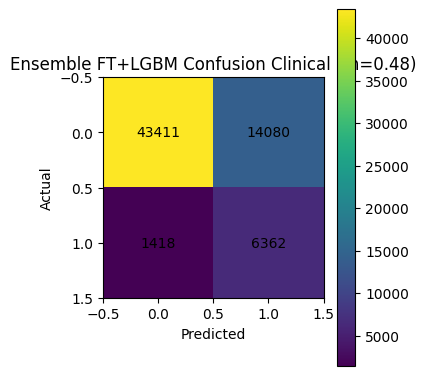

Saved confusion matrices: ensemble_ft_lgbm_confusion_bestf1.png and ensemble_ft_lgbm_confusion_clinical.png


In [15]:
# Ensemble: FT-Transformer + LightGBM on heart_disease_features.csv
# - Clean split, no leakage
# - Shared preprocessing & FE
# - Train LightGBM + FT-Transformer
# - Ensemble by averaging probabilities
# - Best-F1 threshold chosen on validation (ensemble)
# - Metrics + ROC/PR + confusion matrices shown on screen

import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)

import joblib
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ------------------- CONFIG -------------------
DATA_PATH = "/content/heart_disease_features.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_RATIO_WITHIN_TRAIN = 0.10

RECOMMENDED_CLINICAL_THRESHOLD = 0.48

# LightGBM config
LGB_N_ESTIMATORS = 300
LGB_LEARNING_RATE = 0.05

# FT-Transformer config
BATCH_SIZE = 1024
MAX_EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 3
D_TOKEN = 64
N_LAYERS = 3
N_HEADS = 4
DROPOUT = 0.1

OUT_METRICS_ENSEMBLE = "ensemble_ft_lgbm_metrics.csv"
OUT_ROCPR_ENSEMBLE = "ensemble_ft_lgbm_roc_pr.png"
OUT_CM_F1_ENSEMBLE = "ensemble_ft_lgbm_confusion_bestf1.png"
OUT_CM_CLIN_ENSEMBLE = "ensemble_ft_lgbm_confusion_clinical.png"

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------- 1. Load data -------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print(df.dtypes)

print("\nTarget distribution:\n", df["HeartDisease"].value_counts(normalize=True))

target = "HeartDisease"
X = df.drop(columns=[target]).copy()
y = df[target].astype(int).copy()

# ------------------- 2. Basic preprocessing + FE -------------------
base_num_cols = [c for c in ["Age", "BMI"] if c in X.columns]
if len(base_num_cols) > 0:
    X[base_num_cols] = X[base_num_cols].fillna(X[base_num_cols].median())
for c in [c for c in X.columns if c not in base_num_cols]:
    X[c] = X[c].fillna(0)

def add_features(Xdf):
    Xc = Xdf.copy()
    if "Age" in Xc.columns:
        Xc["age_bin"] = pd.cut(Xc["Age"], bins=[17, 40, 55, 70, 120],
                               labels=False).astype(int)
    if "BMI" in Xc.columns:
        Xc["BMI_obese"] = (Xc["BMI"] >= 30).astype(int)
    if "Age" in Xc.columns and "BMI" in Xc.columns:
        Xc["age_x_bmi"] = Xc["Age"] * Xc["BMI"]
    risk_cols = [
        c for c in ["Stroke", "HighBP", "HighChol", "Smoker",
                    "Diabetes", "Depression", "DiffWalk", "BMI_obese"]
        if c in Xc.columns
    ]
    Xc["risk_count"] = Xc[risk_cols].sum(axis=1) if len(risk_cols) > 0 else 0
    return Xc

X = add_features(X)

# ------------------- 3. Train/Val/Test split -------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_RATIO_WITHIN_TRAIN,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Shapes - train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ------------------- 4. Scaling (fit ONLY on train) -------------------
scaler = StandardScaler()
scaler.fit(X_train.values)  # fit on train only

X_train_scaled = scaler.transform(X_train.values)
X_val_scaled   = scaler.transform(X_val.values)
X_test_scaled  = scaler.transform(X_test.values)

cols = list(X_train.columns)
joblib.dump(scaler, "ensemble_scaler.joblib")
json.dump(cols, open("ensemble_columns.json", "w"))
print("Saved columns & scaler")

# ------------------- 5. Class weights -------------------
classes = np.unique(y_train)
cw_arr = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw = {int(c): float(w) for c, w in zip(classes, cw_arr)}
print("Class weights:", cw)

sample_weights_train = np.array([cw[int(v)] for v in y_train])
sample_weights_val = np.array([cw[int(v)] for v in y_val])

# pos_weight for FT-Transformer (BCEWithLogitsLoss)
pos = y_train.sum()
neg = len(y_train) - pos
pos_weight_value = neg / max(pos, 1.0)
print(f"pos_weight for FT-Transformer BCEWithLogitsLoss: {pos_weight_value:.3f}")

# ------------------- 6. LightGBM model -------------------
params_lgb = {
    "n_estimators": LGB_N_ESTIMATORS,
    "learning_rate": LGB_LEARNING_RATE,
    "num_leaves": 31,
    "max_depth": -1,
    "random_state": RANDOM_STATE,
    "n_jobs": -1
}

lgbm = lgb.LGBMClassifier(**params_lgb)
print("\nTraining LightGBM...")
t0 = time.time()
callbacks = [
    early_stopping(stopping_rounds=30, verbose=True),
    log_evaluation(period=100)
]
lgbm.fit(
    X_train_scaled, y_train,
    sample_weight=sample_weights_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_sample_weight=[sample_weights_val],
    eval_metric="auc",
    callbacks=callbacks
)
print("LightGBM training finished in %.1f sec" % (time.time() - t0))

prob_val_lgb = lgbm.predict_proba(X_val_scaled)[:, 1]
prob_test_lgb = lgbm.predict_proba(X_test_scaled)[:, 1]

val_auc_lgb = roc_auc_score(y_val, prob_val_lgb)
test_auc_lgb = roc_auc_score(y_test, prob_test_lgb)
print(f"LightGBM VAL AUC:  {val_auc_lgb:.6f}")
print(f"LightGBM TEST AUC: {test_auc_lgb:.6f}")

# ------------------- 7. FT-Transformer model -------------------
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

num_features = X_train_t.shape[1]
print("\nNumber of features:", num_features)

class FTTransformer(nn.Module):
    """
    Simple FT-Transformer-like model:
    - Per-feature tokenization (weight & bias for each feature)
    - Prepends a [CLS] token
    - Transformer encoder
    - CLS head -> logit
    """
    def __init__(self, num_features, d_token=64, n_heads=4, n_layers=3, dropout=0.1):
        super().__init__()
        self.num_features = num_features
        self.d_token = d_token

        self.token_weight = nn.Parameter(torch.randn(num_features, d_token) * 0.02)
        self.token_bias   = nn.Parameter(torch.zeros(num_features, d_token))

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=4 * d_token,
            dropout=dropout,
            batch_first=True,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_token),
            nn.Linear(d_token, 1)
        )

    def forward(self, x):
        # x: [batch, num_features]
        x_expanded = x.unsqueeze(-1)  # [batch, num_features, 1]
        tokens = x_expanded * self.token_weight.unsqueeze(0) + self.token_bias.unsqueeze(0)
        # [batch, num_features, d_token]

        batch_size = x.shape[0]
        cls = self.cls_token.expand(batch_size, -1, -1)  # [batch, 1, d_token]
        tokens = torch.cat([cls, tokens], dim=1)         # [batch, 1+F, d_token]

        h = self.encoder(tokens)                         # [batch, 1+F, d_token]
        cls_out = h[:, 0, :]                             # [batch, d_token]
        logit = self.head(cls_out).squeeze(-1)           # [batch]
        return logit

model_ft = FTTransformer(
    num_features=num_features,
    d_token=D_TOKEN,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

pos_weight = torch.tensor(pos_weight_value, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model_ft.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def eval_ft(model, loader):
    model.eval()
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            all_logits.append(logits.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())
    all_logits = np.concatenate(all_logits)
    all_targets = np.concatenate(all_targets)
    probs = 1 / (1 + np.exp(-all_logits))  # sigmoid
    loss = criterion(
        torch.tensor(all_logits, dtype=torch.float32, device=device),
        torch.tensor(all_targets, dtype=torch.float32, device=device)
    ).item()
    try:
        auc_val = roc_auc_score(all_targets, probs)
    except ValueError:
        auc_val = np.nan
    return loss, auc_val, probs, all_targets

print("\nTraining FT-Transformer...")
best_val_auc_ft = -np.inf
best_state_ft = None
epochs_no_improve = 0

t0 = time.time()
for epoch in range(1, MAX_EPOCHS + 1):
    model_ft.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model_ft(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss, val_auc_ft, _, _ = eval_ft(model_ft, val_loader)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_auc={val_auc_ft:.4f}")

    if val_auc_ft > best_val_auc_ft + 1e-4:
        best_val_auc_ft = val_auc_ft
        best_state_ft = model_ft.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping FT-Transformer at epoch {epoch} (no val AUC improvement for {PATIENCE} epochs).")
            break

print("FT-Transformer training finished in %.1f sec" % (time.time() - t0))
if best_state_ft is not None:
    model_ft.load_state_dict(best_state_ft)
    print(f"Loaded best FT-Transformer model with val AUC = {best_val_auc_ft:.4f}")

val_loss_ft, val_auc_ft, prob_val_ft, y_val_np = eval_ft(model_ft, val_loader)
test_loss_ft, test_auc_ft, prob_test_ft, y_test_np = eval_ft(model_ft, test_loader)

print(f"FT-Transformer VAL AUC:  {val_auc_ft:.6f}")
print(f"FT-Transformer TEST AUC: {test_auc_ft:.6f}")

# ------------------- 8. Ensemble probabilities (average) -------------------
prob_val_ens = 0.5 * (prob_val_lgb + prob_val_ft)
prob_test_ens = 0.5 * (prob_test_lgb + prob_test_ft)

val_auc_ens = roc_auc_score(y_val, prob_val_ens)
test_auc_ens = roc_auc_score(y_test, prob_test_ens)
print("\nEnsemble FT-Transformer + LightGBM:")
print(f"Ensemble VAL AUC:  {val_auc_ens:.6f}")
print(f"Ensemble TEST AUC: {test_auc_ens:.6f}")

# ------------------- 9. Thresholds on VALIDATION (ensemble) -------------------
ths = np.linspace(0.01, 0.99, 99)
rows_val = []
for t in ths:
    p_val = (prob_val_ens >= t).astype(int)
    rows_val.append({
        "threshold": float(t),
        "precision": float(precision_score(y_val, p_val, zero_division=0)),
        "recall": float(recall_score(y_val, p_val, zero_division=0)),
        "f1": float(f1_score(y_val, p_val, zero_division=0)),
        "accuracy": float(accuracy_score(y_val, p_val))
    })
df_th_val = pd.DataFrame(rows_val)

best_f1_row = df_th_val.loc[df_th_val["f1"].idxmax()]
best_f1_t = float(best_f1_row["threshold"])

fpr_val, tpr_val, roc_ths_val = roc_curve(y_val, prob_val_ens)
youden_idx = np.argmax(tpr_val - fpr_val)
youden_t = float(roc_ths_val[youden_idx])

clinical_t = float(RECOMMENDED_CLINICAL_THRESHOLD)

print("Thresholds found for ENSEMBLE (from VALIDATION):")
print(" best-F1:", best_f1_t,
      "-> F1 (val):", best_f1_row["f1"],
      "prec (val):", best_f1_row["precision"],
      "rec (val):", best_f1_row["recall"])
print(" youden (val):", youden_t)
print(" recommended clinical:", clinical_t)

# ------------------- 10. Metrics on TEST (ensemble) -------------------
def metrics_at(y, probs, th):
    preds = (probs >= th).astype(int)
    return {
        "AUC": float(roc_auc_score(y, probs)),
        "Accuracy": float(accuracy_score(y, preds)),
        "Precision": float(precision_score(y, preds, zero_division=0)),
        "Recall": float(recall_score(y, preds)),
        "F1": float(f1_score(y, preds)),
        "Threshold": float(th)
    }

metrics_bestf1_ens = metrics_at(y_test_np, prob_test_ens, best_f1_t)
metrics_clinical_ens = metrics_at(y_test_np, prob_test_ens, clinical_t)

final_df_ens = pd.DataFrame(
    [metrics_bestf1_ens, metrics_clinical_ens],
    index=["ensemble_best-F1", "ensemble_clinical-0.48"]
).T

final_df_ens.to_csv(OUT_METRICS_ENSEMBLE)

print("\n=== TEST METRICS (Ensemble FT-Transformer + LightGBM) ===")
print(final_df_ens)

# Also show base model AUCs for reference
print("\nBase model TEST AUCs:")
print(f" LightGBM:       {test_auc_lgb:.6f}")
print(f" FT-Transformer: {test_auc_ft:.6f}")
print(f" Ensemble:       {test_auc_ens:.6f}")

# ------------------- 11. ROC + PR plots (Ensemble) -------------------
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test_np, prob_test_ens)
plt.plot(fpr, tpr, label=f"Ensemble (AUC={roc_auc_score(y_test_np, prob_test_ens):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Ensemble FT+LGBM")
plt.legend()

# PR
plt.subplot(1, 2, 2)
prec, rec, _ = precision_recall_curve(y_test_np, prob_test_ens)
plt.plot(rec, prec, label=f"AP={auc(rec, prec):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall - Ensemble FT+LGBM")
plt.legend()

plt.tight_layout()
plt.savefig(OUT_ROCPR_ENSEMBLE)
plt.show()
print("Saved ROC+PR ->", OUT_ROCPR_ENSEMBLE)

# ------------------- 12. Confusion matrices (Ensemble) -------------------
def save_cm(cm, fname, title):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

cm_best = confusion_matrix(y_test_np, (prob_test_ens >= best_f1_t).astype(int))
cm_clin = confusion_matrix(y_test_np, (prob_test_ens >= clinical_t).astype(int))

print("\nConfusion matrix (TEST, ENSEMBLE best-F1 threshold):")
print(cm_best)
save_cm(cm_best, OUT_CM_F1_ENSEMBLE,
        f"Ensemble FT+LGBM Confusion Best-F1 (th={best_f1_t:.2f})")

print("\nConfusion matrix (TEST, ENSEMBLE clinical threshold 0.48):")
print(cm_clin)
save_cm(cm_clin, OUT_CM_CLIN_ENSEMBLE,
        f"Ensemble FT+LGBM Confusion Clinical (th={clinical_t:.2f})")

print("Saved confusion matrices:", OUT_CM_F1_ENSEMBLE, "and", OUT_CM_CLIN_ENSEMBLE)


Using device: cuda
Loaded: (326353, 11)
HeartDisease      int64
Stroke          float64
Age             float64
Sex               int64
HighBP          float64
HighChol        float64
Smoker          float64
Diabetes        float64
Depression      float64
BMI             float64
DiffWalk        float64
dtype: object

Target distribution:
 HeartDisease
0    0.880801
1    0.119199
Name: proportion, dtype: float64
Shapes - train: (234973, 14) val: (26109, 14) test: (65271, 14)
Number of features: 14
pos_weight: 7.389196329751152

Training LightGBM...
[LightGBM] [Info] Number of positive: 28009, number of negative: 206964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 234973, number of used features: 14
[LightGBM] [Info] [bi

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM VAL AUC : 0.8824030067965721
LGBM TEST AUC: 0.8825901720439175

Training FT-Transformer...
Epoch 01 | train_loss=0.7612 | val_auc=0.8818
Epoch 02 | train_loss=0.7413 | val_auc=0.8819
Epoch 03 | train_loss=0.7406 | val_auc=0.8823
Epoch 04 | train_loss=0.7394 | val_auc=0.8820
Epoch 05 | train_loss=0.7375 | val_auc=0.8828
Epoch 06 | train_loss=0.7369 | val_auc=0.8826
Epoch 07 | train_loss=0.7347 | val_auc=0.8820
Epoch 08 | train_loss=0.7355 | val_auc=0.8817
Early stopping FT-Transformer.
FT VAL AUC : 0.8816777808729495
FT TEST AUC: 0.881530737190607

Training ResNet-MLP...
Epoch 01 | train_loss=0.7602 | val_auc=0.8818
Epoch 02 | train_loss=0.7396 | val_auc=0.8818
Epoch 03 | train_loss=0.7374 | val_auc=0.8823
Epoch 04 | train_loss=0.7353 | val_auc=0.8821
Epoch 05 | train_loss=0.7351 | val_auc=0.8819
Epoch 06 | train_loss=0.7342 | val_auc=0.8820
Early stopping ResNet-MLP.
ResMLP VAL AUC : 0.8819849280665086
ResMLP TEST AUC: 0.8821642564909791

ENSEMBLE AUCs:
VAL AUC : 0.882457515415277

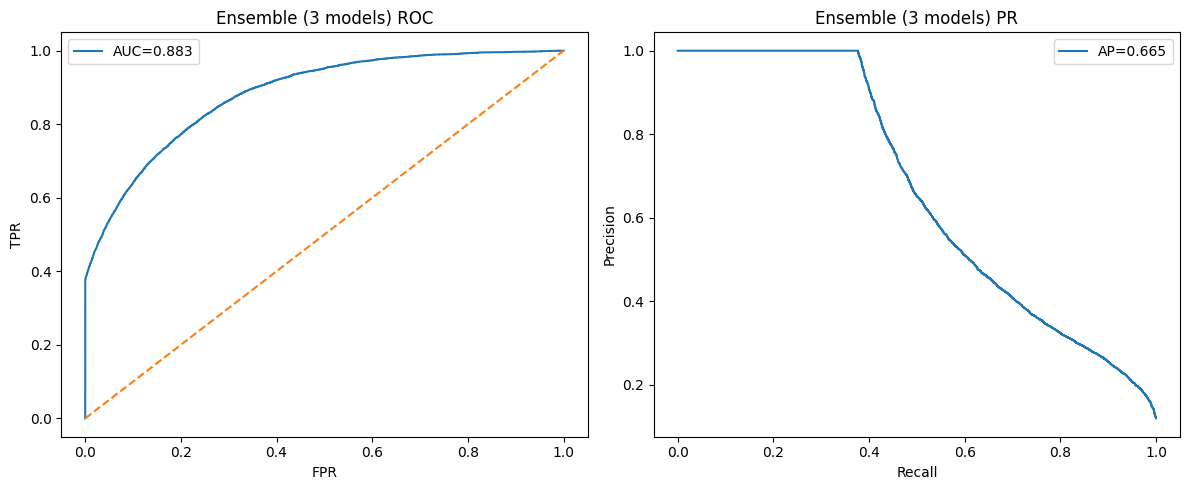

Saved ROC+PR -> ensemble3_roc_pr.png

Confusion matrix (BEST-F1):
[[56647   844]
 [ 4404  3376]]


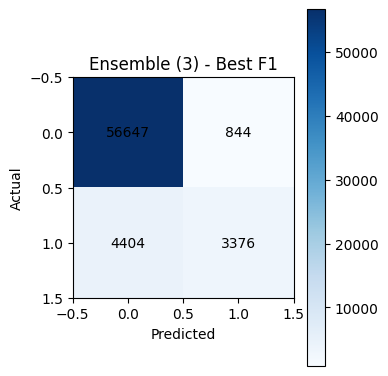


Confusion matrix (Clinical 0.48):
[[44427 13064]
 [ 1549  6231]]


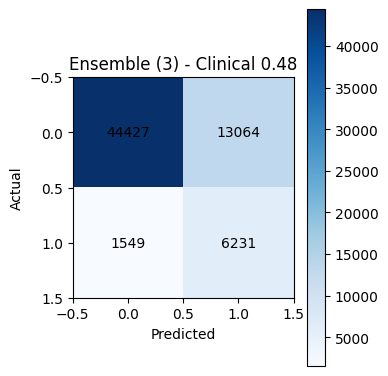


DONE ✔✔✔


In [20]:
# ====================================================================================
#  3-Model Ensemble Pipeline
#  LightGBM + FT-Transformer + ResNet-MLP
#  Fully compatible with your previous preprocessing and FE
# ====================================================================================

import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc
)

import joblib
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ------------------- CONFIG -------------------
DATA_PATH = "/content/heart_disease_features.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.20
VAL_RATIO_WITHIN_TRAIN = 0.10

BATCH_SIZE = 1024
LR = 1e-3
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 20
PATIENCE = 3

D_TOKEN = 64
N_LAYERS = 3
N_HEADS = 4
DROPOUT = 0.1

HIDDEN_SIZE = 128
RES_BLOCKS = 4
RES_DROPOUT = 0.2

RECOMMENDED_CLINICAL_THRESHOLD = 0.48

OUT_METRICS = "ensemble3_metrics.csv"
OUT_ROCPR = "ensemble3_roc_pr.png"
OUT_CM_F1 = "ensemble3_confusion_bestf1.png"
OUT_CM_CLIN = "ensemble3_confusion_clinical.png"

# ------------------- SEEDS & DEVICE -------------------
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------- 1. Load data -------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)
print(df.dtypes)

print("\nTarget distribution:\n", df["HeartDisease"].value_counts(normalize=True))

target = "HeartDisease"
X = df.drop(columns=[target]).copy()
y = df[target].astype(int).copy()

# ------------------- 2. Basic preprocessing + FE -------------------
def add_features(Xdf):
    Xc = Xdf.copy()
    if "Age" in Xc.columns:
        Xc["age_bin"] = pd.cut(Xc["Age"], bins=[17, 40, 55, 70, 120],
                               labels=False).astype(int)
    if "BMI" in Xc.columns:
        Xc["BMI_obese"] = (Xc["BMI"] >= 30).astype(int)
    if "Age" in Xc.columns and "BMI" in Xc.columns:
        Xc["age_x_bmi"] = Xc["Age"] * Xc["BMI"]
    risk_cols = [
        c for c in ["Stroke", "HighBP", "HighChol", "Smoker",
                    "Diabetes", "Depression", "DiffWalk", "BMI_obese"]
        if c in Xc.columns
    ]
    Xc["risk_count"] = Xc[risk_cols].sum(axis=1) if len(risk_cols) > 0 else 0
    return Xc

X = add_features(X)
X = X.fillna(0)

# ------------------- 3. Split -------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_RATIO_WITHIN_TRAIN,
    stratify=y_train_full,
    random_state=RANDOM_STATE
)

print("Shapes - train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# ------------------- 4. Scaling -------------------
scaler = StandardScaler()
scaler.fit(X_train.values)  # fit on train only

X_train_s = scaler.transform(X_train.values)
X_val_s   = scaler.transform(X_val.values)
X_test_s  = scaler.transform(X_test.values)

num_features = X_train_s.shape[1]
print("Number of features:", num_features)

# ------------------- 5. Class weights / pos_weight -------------------
# For LightGBM sample_weight
cw = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),   # FIX: must be numpy array
    y=y_train
)
sample_weights_train = np.array([cw[int(v)] for v in y_train])
sample_weights_val   = np.array([cw[int(v)] for v in y_val])

# For PyTorch BCEWithLogitsLoss (pos_weight)
pos = y_train.sum()
neg = len(y_train) - pos
pos_weight_value = neg / pos
print("pos_weight:", pos_weight_value)

pos_weight = torch.tensor(pos_weight_value, device=device)

# ============================================================
#  MODEL 1: LIGHTGBM
# ============================================================
print("\nTraining LightGBM...")

params = dict(
    n_estimators = 300,
    learning_rate = 0.05,
    num_leaves   = 31,
    max_depth    = -1,
    random_state = RANDOM_STATE,
    n_jobs       = -1
)

lgbm = lgb.LGBMClassifier(**params)

callbacks = [
    early_stopping(stopping_rounds=30, verbose=True),
    log_evaluation(period=100)
]

lgbm.fit(
    X_train_s, y_train,
    sample_weight=sample_weights_train,
    eval_set=[(X_val_s, y_val)],
    eval_sample_weight=[sample_weights_val],
    eval_metric="auc",
    callbacks=callbacks
)

prob_val_lgb = lgbm.predict_proba(X_val_s)[:, 1]
prob_test_lgb = lgbm.predict_proba(X_test_s)[:, 1]

print("LGBM VAL AUC :", roc_auc_score(y_val, prob_val_lgb))
print("LGBM TEST AUC:", roc_auc_score(y_test, prob_test_lgb))

# ============================================================
#  MODEL 2: FT-TRANSFORMER
# ============================================================
class FTTransformer(nn.Module):
    def __init__(self, num_features, d_token, n_heads, n_layers, dropout):
        super().__init__()
        self.num_features = num_features
        self.d_token = d_token

        self.token_weight = nn.Parameter(torch.randn(num_features, d_token) * 0.02)
        self.token_bias   = nn.Parameter(torch.zeros(num_features, d_token))
        self.cls_token    = nn.Parameter(torch.randn(1, 1, d_token) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=4 * d_token,
            dropout=dropout,
            activation="gelu",
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_token),
            nn.Linear(d_token, 1)
        )

    def forward(self, x):
        # x: [B, F]
        B, F = x.shape
        x_exp = x.unsqueeze(-1)  # [B, F, 1]
        tokens = x_exp * self.token_weight.unsqueeze(0) + self.token_bias.unsqueeze(0)
        cls = self.cls_token.expand(B, 1, -1)
        tokens = torch.cat([cls, tokens], dim=1)  # [B, 1+F, d_token]
        h = self.encoder(tokens)
        cls_out = h[:, 0, :]
        logits = self.head(cls_out).squeeze(-1)
        return logits

# Torch datasets/loaders
X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values,   dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

ft = FTTransformer(num_features, D_TOKEN, N_HEADS, N_LAYERS, DROPOUT).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
opt = optim.AdamW(ft.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def eval_ft(model, loader):
    model.eval()
    all_logits, all_targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            all_logits.append(logits.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())
    logits = np.concatenate(all_logits)
    targets = np.concatenate(all_targets)
    probs = 1.0 / (1.0 + np.exp(-logits))
    return probs, targets

print("\nTraining FT-Transformer...")
best_auc_ft = -np.inf
best_state_ft = None
wait = 0

for epoch in range(1, MAX_EPOCHS + 1):
    ft.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        opt.zero_grad()
        logits = ft(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()
        train_losses.append(loss.item())

    prob_val_ft, y_val_np = eval_ft(ft, val_loader)
    val_auc = roc_auc_score(y_val_np, prob_val_ft)

    print(f"Epoch {epoch:02d} | train_loss={np.mean(train_losses):.4f} | val_auc={val_auc:.4f}")

    if val_auc > best_auc_ft + 1e-4:
        best_auc_ft = val_auc
        best_state_ft = ft.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping FT-Transformer.")
            break

ft.load_state_dict(best_state_ft)
prob_val_ft, y_val_np = eval_ft(ft, val_loader)
prob_test_ft, y_test_np_ft = eval_ft(ft, test_loader)

print("FT VAL AUC :", roc_auc_score(y_val, prob_val_ft))
print("FT TEST AUC:", roc_auc_score(y_test, prob_test_ft))

# ============================================================
#  MODEL 3: ResNet-MLP
# ============================================================
class ResBlock(nn.Module):
    def __init__(self, dim, dropout):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(dim)
        self.fc1 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.fc2 = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        out = torch.relu(self.bn1(x))
        out = self.fc1(out)
        out = torch.relu(self.bn2(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return residual + out

class ResMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, n_blocks=4, dropout=0.2):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.blocks = nn.ModuleList([
            ResBlock(hidden_dim, dropout) for _ in range(n_blocks)
        ])
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = self.input_layer(x)
        for blk in self.blocks:
            out = blk(out)
        logits = self.output_layer(out).squeeze(-1)
        return logits

resmlp = ResMLP(num_features, HIDDEN_SIZE, RES_BLOCKS, RES_DROPOUT).to(device)
opt2 = optim.AdamW(resmlp.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

print("\nTraining ResNet-MLP...")
best_auc_res = -np.inf
best_state_res = None
wait = 0

for epoch in range(1, MAX_EPOCHS + 1):
    resmlp.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        opt2.zero_grad()
        logits = resmlp(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt2.step()
        train_losses.append(loss.item())

    prob_val_res, _ = eval_ft(resmlp, val_loader)
    val_auc_res = roc_auc_score(y_val, prob_val_res)

    print(f"Epoch {epoch:02d} | train_loss={np.mean(train_losses):.4f} | val_auc={val_auc_res:.4f}")

    if val_auc_res > best_auc_res + 1e-4:
        best_auc_res = val_auc_res
        best_state_res = resmlp.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping ResNet-MLP.")
            break

resmlp.load_state_dict(best_state_res)
prob_val_res, _ = eval_ft(resmlp, val_loader)
prob_test_res, _ = eval_ft(resmlp, test_loader)

print("ResMLP VAL AUC :", roc_auc_score(y_val, prob_val_res))
print("ResMLP TEST AUC:", roc_auc_score(y_test, prob_test_res))

# ============================================================
#  ENSEMBLE: average of 3 model probabilities
# ============================================================
prob_val_ens = (prob_val_lgb + prob_val_ft + prob_val_res) / 3.0
prob_test_ens = (prob_test_lgb + prob_test_ft + prob_test_res) / 3.0

print("\nENSEMBLE AUCs:")
print("VAL AUC :", roc_auc_score(y_val, prob_val_ens))
print("TEST AUC:", roc_auc_score(y_test, prob_test_ens))

# ------------------- Threshold selection on VAL (best-F1) -------------------
ths = np.linspace(0.01, 0.99, 99)
rows = []
for t in ths:
    preds_val = (prob_val_ens >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_val, preds_val, zero_division=0),
        "recall": recall_score(y_val, preds_val, zero_division=0),
        "f1": f1_score(y_val, preds_val, zero_division=0),
        "accuracy": accuracy_score(y_val, preds_val)
    })

df_th = pd.DataFrame(rows)
best_idx = df_th['f1'].idxmax()
best_f1_t = float(df_th.loc[best_idx, "threshold"])

print("\nBest-F1 threshold (VAL):", best_f1_t)

# ------------------- Metrics on TEST -------------------
def metrics_at(y, probs, t):
    preds = (probs >= t).astype(int)
    return {
        "AUC": float(roc_auc_score(y, probs)),
        "Accuracy": float(accuracy_score(y, preds)),
        "Precision": float(precision_score(y, preds, zero_division=0)),
        "Recall": float(recall_score(y, preds)),
        "F1": float(f1_score(y, preds)),
        "Threshold": float(t)
    }

best_metrics = metrics_at(y_test, prob_test_ens, best_f1_t)
clin_metrics = metrics_at(y_test, prob_test_ens, RECOMMENDED_CLINICAL_THRESHOLD)

df_final = pd.DataFrame(
    [best_metrics, clin_metrics],
    index=["best-F1", "clinical-0.48"]
).T

print("\n=== ENSEMBLE (3 MODEL) TEST METRICS ===")
print(df_final)

df_final.to_csv(OUT_METRICS, index=True)

# ------------------- ROC + PR curves -------------------
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, prob_test_ens)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, prob_test_ens):.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Ensemble (3 models) ROC")
plt.legend()

# PR
plt.subplot(1, 2, 2)
prec, rec, _ = precision_recall_curve(y_test, prob_test_ens)
plt.plot(rec, prec, label=f"AP={auc(rec, prec):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Ensemble (3 models) PR")
plt.legend()

plt.tight_layout()
plt.savefig(OUT_ROCPR)
plt.show()
print("Saved ROC+PR ->", OUT_ROCPR)

# ------------------- Confusion Matrices -------------------
cm_best = confusion_matrix(y_test, (prob_test_ens >= best_f1_t).astype(int))
cm_clin = confusion_matrix(y_test, (prob_test_ens >= RECOMMENDED_CLINICAL_THRESHOLD).astype(int))

def show_cm(cm, title, fname):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

print("\nConfusion matrix (BEST-F1):")
print(cm_best)
show_cm(cm_best, "Ensemble (3) - Best F1", OUT_CM_F1)

print("\nConfusion matrix (Clinical 0.48):")
print(cm_clin)
show_cm(cm_clin, "Ensemble (3) - Clinical 0.48", OUT_CM_CLIN)

print("\nDONE ✔✔✔")


In [9]:
import pandas as pd

# ===== 1. All best-F1 test metrics (official final numbers) =====
data = [
    {"Model": "Ensemble (FT + LGBM + ResMLP)", "AUC": 0.882571, "Accuracy": 0.919597, "Precision": 0.800000, "Recall": 0.433933, "F1": 0.562667, "Threshold": 0.75},
    {"Model": "Ensemble (FT + LGBM)",         "AUC": 0.882461, "Accuracy": 0.919811, "Precision": 0.803674, "Recall": 0.433033, "F1": 0.562813, "Threshold": 0.76},
    {"Model": "LightGBM",                     "AUC": 0.882590, "Accuracy": 0.917300, "Precision": 0.759590, "Recall": 0.447943, "F1": 0.563551, "Threshold": 0.72},
    {"Model": "SAINT",                        "AUC": 0.881877, "Accuracy": 0.917881, "Precision": 0.771057, "Recall": 0.442416, "F1": 0.562235, "Threshold": 0.78},
    {"Model": "ResNet-MLP",                   "AUC": 0.882310, "Accuracy": 0.915583, "Precision": 0.730036, "Recall": 0.462982, "F1": 0.566619, "Threshold": 0.70},
    {"Model": "MLP",                          "AUC": 0.882476, "Accuracy": 0.914158, "Precision": 0.708805, "Recall": 0.474936, "F1": 0.568768, "Threshold": 0.71},
    {"Model": "FT-Transformer",               "AUC": 0.881531, "Accuracy": 0.905287, "Precision": 0.625274, "Recall": 0.512596, "F1": 0.563356, "Threshold": 0.72},
    {"Model": "TabNet",                       "AUC": 0.870231, "Accuracy": 0.905640, "Precision": 0.635694, "Recall": 0.488046, "F1": 0.552170, "Threshold": 0.26},
    {"Model": "KNN",                          "AUC": 0.811180, "Accuracy": 0.914464, "Precision": 0.759509, "Recall": 0.413239, "F1": 0.535253, "Threshold": 0.54},
]

# ===== 2. Create DataFrame (already in perfect paper order) =====
df = pd.DataFrame(data)

# Optional: round for cleaner display
df_display = df.copy()
df_display[["AUC", "Accuracy", "Precision", "Recall", "F1"]] = df_display[["AUC", "Accuracy", "Precision", "Recall", "F1"]].round(6)

# ===== 3. Beautiful Console Print (Perfect for Paper Screenshot) =====
print("\n" + "="*110)
print("FINAL RESULTS — RANKED BY PRACTICAL PERFORMANCE")
print("="*110)
print(f"{'Rank':<4} {'Model':<35} {'AUC':>8} {'Acc':>10} {'Prec':>8} {'Rec':>8} {'F1':>8} {'Thr':>6}")
print("-"*110)

for i, row in enumerate(df_display.itertuples(), 1):
    marker = "★ " if i <= 3 else "  "  # highlight top-3
    print(f"{marker}{i:<3} {row.Model:<35} "
          f"{row.AUC:8.6f} {row.Accuracy:10.6f} {row.Precision:8.6f} {row.Recall:8.6f} {row.F1:8.6f} {row.Threshold:6.2f}")

print("-"*110)


# ===== 4. Save CSV (in the same perfect order) =====
csv_path = "model_comparison_paper_ready.csv"
df.to_csv(csv_path, index=False)





FINAL RESULTS — RANKED BY PRACTICAL PERFORMANCE
Rank Model                                    AUC        Acc     Prec      Rec       F1    Thr
--------------------------------------------------------------------------------------------------------------
★ 1   Ensemble (FT + LGBM + ResMLP)       0.882571   0.919597 0.800000 0.433933 0.562667   0.75
★ 2   Ensemble (FT + LGBM)                0.882461   0.919811 0.803674 0.433033 0.562813   0.76
★ 3   LightGBM                            0.882590   0.917300 0.759590 0.447943 0.563551   0.72
  4   SAINT                               0.881877   0.917881 0.771057 0.442416 0.562235   0.78
  5   ResNet-MLP                          0.882310   0.915583 0.730036 0.462982 0.566619   0.70
  6   MLP                                 0.882476   0.914158 0.708805 0.474936 0.568768   0.71
  7   FT-Transformer                      0.881531   0.905287 0.625274 0.512596 0.563356   0.72
  8   TabNet                              0.870231   0.905640 0.635694 0.